# Coronavirus COVID-19 Cases in Finland

__Bernardo Di Chiara, Data Analyst__

http://fi.linkedin.com/in/bernardodichiara

_Last plotted day: see the end of the file_

## Table of Contents

[1. Executive Summary](#1.)<br>
<font color='white'>....</font>[1.1. References](#1.1.)<br>
[2. Setup](#2.)<br>
[3. Defining the Needed Functions](#3.)<br>
<font color='white'>....</font>[3.1. Dataframes and lists handling](#3.1.)<br>
<font color='white'>....</font>[3.2. Plots](#3.2.)<br>
<font color='white'>....</font>[3.3. Project-specific functions](#3.3.)<br>
[4. Dumping and Collecting the Data](#4.)<br>
[5. Data Analysis](#5.)<br>
<font color='white'>....</font>[5.1. Summary](#5.1.)<br>
<font color='white'>....</font>[5.2. Preliminary Data Analysis](#5.2.)<br>
<font color='white'>....</font>[5.3. Data Cleansing](#5.3.)<br>
<font color='white'>....</font>[5.4. Data Preparation](#5.4.)<br>
<font color='white'>............</font>[5.4.1. New datasets with no NaN, no GPS coordinates / list of days / list of Countries](#5.4.1.)<br>
<font color='white'>............</font>[5.4.2. Population age data](#5.4.2.)<br>
<font color='white'>............</font>[5.4.3. World Data](#5.4.3.)<br>
<font color='white'>............</font>[5.4.4. Finnish Data](#5.4.4.)<br>
<font color='white'>............</font>[5.4.5. Data from other Scandinavian Countries](#5.4.5.)<br>
<font color='white'>............</font>[5.4.6. Data from other European Countries](#5.4.6.)<br>
<font color='white'>............</font>[5.4.7. Data from UK](#5.4.7.)<br>
<font color='white'>............</font>[5.4.8. Data from US](#5.4.8.)<br>
<font color='white'>............</font>[5.4.9. Data from China](#5.4.9.)<br>
<font color='white'>....</font>[5.5. Summary of the created datasets](#5.5.)<br>
[6. Domain-Specific Concepts](#6.)<br>
[7. Data Visualization](#7.)<br>
<font color='white'>....</font>[7.1. General Comments to the Plots](#7.1.)<br>
<font color='white'>....</font>[7.2. Finnish Internal Situation](#7.2.)<br>
<font color='white'>....</font>[7.3. Comparison with Other Scandinavian Countries](#7.3.)<br>
<font color='white'>....</font>[7.4. Comparison with Italy and other European Countries](#7.4.)<br>
<font color='white'>....</font>[7.5. Comparison with UK and US](#7.5.)<br>
<font color='white'>....</font>[7.6. Normalizing by Country population](#7.6.)<br>
<font color='white'>....</font>[7.7. Situation in China](#7.7.)<br>
<font color='white'>....</font>[7.8. Situation in Italy](#7.8.)<br>
<font color='white'>....</font>[7.9. World View](#7.9.)<br>
[8. Statistics](#8.)<br>
<font color='white'>....</font>[8.1. World view](#8.1.)<br>
<font color='white'>....</font>[8.2. Top Ten Countries](#8.2.)<br>
<font color='white'>....</font>[8.3. Finland](#8.3.)<br>
[9. Conclusions](#9.)<br>
[10. Acknowledgements](#10.)<br>

## 1. Executive Summary <a name="1."></a>

This notebook contains visualizations related to the spread of the Coronavirus COVID-19 in Finland.

The data is taken from the Johns Hokpins University (JHU) [/1/](https://github.com/CSSEGISandData/COVID-19).

There are a few good dashboards in the Web about to this topic (for example, by Johns Hokpins University [/2/](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) and by Tableau [/3/](https://public.tableau.com/profile/covid.19.data.resource.hub#!/vizhome/COVID-19Cases_15840488375320/COVID-19Cases)). In addition, there is a good site with latest information about Finland broken down by Region [/4/](https://finland-coronavirus-map.netlify.com/). Another very useful source of information is the European Centre for Disease Prevention and Control [/5/](https://www.ecdc.europa.eu/en/novel-coronavirus-china). Still, it might be beneficial to manipulate the data in order, for example, to compare Finnish curves with curves from other Countries.

Having updated charts is very useful both for authorities and for the population in order to make fact-based decisions that help to contain the positive cases so not to overload the hospitals and therefore minimizing the casualties.

Comparing Finnish curves to those of neighboring Countries might provide useful insights since, in addition to the geographical proximity and similar weather, those Countries have certain similarities in culture, behavior patterns and may be genetics.

A line plot containing confirmed cases each day as well as recovered and deceased cases in Finland has been produced. The active cases have been shown in the same plot.

A second line plot containing the new confirmed daily cases in Finland, which shows the speed at which the virus is spreading, has been added.

Finnish curves have been compared to the curves of the other Scandinavian Countries as well as few other European Countries as well as UK and US.

Plots showing the number of confirmed cases per capita have been created to eliminate the population variable from the comparisons.

Finally, plots with worldwide data have been produced.

Bar plots containing data of the most affected Countries have been added.

Due to the criticality of this information, no recommendations are included in this paper. Currently, Doctors and Authorities are the best sources for such recommendations.

**If you are not interested in the code, go to section 6 and onward and focus on the plots, the tables and the plain text.**

**DISCLAIMER:**
    
- The code has not been peer-reviewed. If someone is wishing to do it, please contact the author.
- The data related to the last day might be incomplete.
- More clarifications are contained in section 7 close to the plots.
- See also the [legal disclaimer](Legal.txt).

_The spread of virus follows the rules of mathematics and statistics (Dr. Katharina Hauck, https://www.imperial.ac.uk/people/k.hauck)._

### 1.1. References<a name="1.1."></a>

<sub>/1/ [GitHub Repository by Johns Hokpins University](https://github.com/CSSEGISandData/COVID-19)<br>
https://github.com/CSSEGISandData/COVID-19</sub>

<sub>/2/ [Dashboard by Johns Hokpins University with world-wide view](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6)<br>
https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6</sub>

<sub>/3/ [Dashboard by Tableau with both global and Country-specific data](https://public.tableau.com/profile/covid.19.data.resource.hub#!/vizhome/COVID-19Cases_15840488375320/COVID-19Cases)<br>
https://public.tableau.com/profile/covid.19.data.resource.hub#!/vizhome/COVID-19Cases_15840488375320/COVID-19Cases

<sub>/4/ [Latest news about Finland broken by Region](https://finland-coronavirus-map.netlify.com/)<br>
https://finland-coronavirus-map.netlify.com/
    
<sub>/5/ [European Centre for Disease Prevention and Control](https://www.ecdc.europa.eu/en/novel-coronavirus-china)<br>
https://www.ecdc.europa.eu/en/novel-coronavirus-china
    
<sub>/6/ [Coursera: Let's Talk About COVID-19](https://www.coursera.org/learn/covid-19/home/welcome)<br>
https://www.coursera.org/learn/covid-19/home/welcome

## 2. Setup <a name="2."></a>

In [1]:
# Importing the needed packages
import os
import datetime as dt
import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying all the dafaframe columns
pd.set_option('display.max_columns', None)

## 3. Defining the Needed Functions <a name="3."></a>

### 3.1. Dataframes and lists handling<a name="3.1."></a>

In [2]:
def df_basic_data(dfname):
    '''
    This function prints basic information about a given dataframe.
    The function needs as input parameters the dataframe name.
    '''

    import pandas as pd

    # Fetching the dataframe name
    name = [x for x in globals() if globals()[x] is dfname][0]
    print("Dataframe name:", name, "\n")
    print("Dataframe length:", len(dfname), "\n")
    print("Number of columns:", len(dfname.columns), "\n")
    # Columns data types
    data_types = dfname.dtypes
    # Distint values
    distint_values = dfname.apply(pd.Series.nunique)
    # Amount of null values
    null_values = dfname.isnull().sum()
    print("Dataframe's columns names, column data types, amount of distint "
          "(non null) values\n"
          "and amount of null values for each column:")
    df_index = ['Data_Type',
                'Amount_of_Distint_Values',
                'Amount_of_Null_Values']
    col_types_dist_null = pd.DataFrame([data_types,
                                        distint_values,
                                        null_values],
                                       index=df_index)
    return col_types_dist_null.transpose()

In [3]:
def calc_increments(listname):
    '''
    This function:
    takes a list,
    calculates the delta between each element and its predecessor,
    returns the result in a new list having the same lenght as the original list
    '''

    # Initializing an empty list of floats to contain the increments
    increments = []
    # Adding zero to the first element
    increments.append(0.0)
    # Looping through all the occurrencies except the first one
    for i in list(range(1, len(listname))):
        # Calculating the increment
        delta = listname[i]-listname[i-1]
        # Adding the result to the list
        increments.append(delta)
    # Returning the result
    return increments

### 3.2. Plots<a name="3.2."></a>

In [4]:
def cust_line_plot(*parameters,
                   figsize_w=8, figsize_h=6,
                   title=None,
                   title_fs=16, title_offset=20,
                   rem_borders=False,
                   label_fs=12, tick_fs=6, 
                   x_label=None,
                   rot=0,
                   y_label=None,
                   legend=False, leg_fs=10,
                   first_line_x=None, first_line_l=None,
                   second_line_x=None, second_line_l=None,
                   third_line_x=None, third_line_l=None):
    """
    This function plots a scatterplot for the provided data
    and customizes the way the chart looks by using the value of
    the provided parameters.

    Keyword arguments:
    parameters       -- A (mandatory) tuple of 5 elements containing:
                        a list with the x values,
                        a list with the y values,
                        a string containing the selected marker,
                        a string containing the selected line style,
                        an integer (from 0 to 9) selecting the seaborn-deep
                        color,
                        a string containing the text for the legend
    figsize_w        -- The width of the plot area
    figsize_w        -- The height of the plot area
    title            -- A string containing the title of the chart
    title_fs         -- The title font size
    title_offset     -- Distance between the title and the top of the chart
    rem_borders      -- If True the top and right borders are removed
                        (default: False)
    label_fs         -- x and y axis labels' font size
    tick_fs          -- The tick values font size
    x_label          -- Label for the x-axis (string)
    rot              -- The rotation angle of the tick values
    y_label          -- Label for the y-axis (string)
    legend           -- A boolean variable that tells if to plot a legend
    leg_fs           -- Font size for the legend
    """

    import matplotlib.pyplot as plt
    import seaborn as sns

    # Creating a new figure
    plt.figure(figsize=(figsize_w, figsize_h))
    # Defining the used style
    color_list = sns.color_palette(palette='deep')
    # Adding a title (with some distance to the top of the plot)
    plt.title(title, fontsize=title_fs, pad=title_offset)
    # Removing the top and right borders if so defined
    if rem_borders is True:
        sns.despine(top=True, right=True, left=False, bottom=False)

    # Initializing an empy list to contain the legend text
    leg_text_l = []
    for param in parameters:
        # Extracting the values given in parameters
        x = param[0]
        y = param[1]
        mark = param[2]
        ls = param[3]
        col_numb = param[4]
        leg_text = param[5]
        # Appending the string to the list
        leg_text_l.append(leg_text)
        # Creating the scatter plots
        plot = plt.plot(x, y, marker=mark, linestyle=ls, color=color_list[col_numb])

    # If a label for the x axis is provided, showing it on the x axis
    if x_label:
        plt.xlabel(x_label, fontsize=label_fs)
    plt.xticks(fontsize=tick_fs, rotation=rot)
    # If a label for the y axis is provided, showing it on the y axis
    if y_label:
        plt.ylabel(y_label, fontsize=label_fs)
    plt.yticks(fontsize=tick_fs)

    # Adding vertical lines
    if first_line_x:
        plt.axvline(x=first_line_x, color='grey', linestyle=':')
        leg_text_l.append(first_line_l)
    if second_line_x:
        plt.axvline(x=second_line_x, color='grey', linestyle='--')
        leg_text_l.append(second_line_l)
    if third_line_x:        
        plt.axvline(x=third_line_x, color='grey', linestyle='-')
        leg_text_l.append(third_line_l)
    
    # Adding a legend
    if legend:
        plt.legend(labels=leg_text_l, fontsize=leg_fs)

    # Showing the plot without additional text
    plt.show()

In [5]:
def cust_bar_plot(parameters,
                  figsize_w=8, figsize_h=6,
                  title=None, title_fs=16, title_offset=20,
                  rem_borders=False,
                  label_fs=12, tick_fs=6,
                  x_label=None,
                  rot=0,
                  y_label=None,
                  legend=False,
                  leg_fs=10,
                  first_line_x=None, first_line_l=None,
                  second_line_x=None, second_line_l=None,
                  third_line_x=None, third_line_l=None):
    """
    This function plots a bar plot for the provided data
    and customizes the way the chart looks by using the value of
    the provided parameters.

    Keyword arguments:
    parameters       -- A (mandatory) tuple of 4 elements containing:
                        a list with the x values,
                        a list with the y values,
                        an integer (from 0 to 9) selecting the seaborn-deep
                        color,
                        a string containing the text for the legend
    figsize_w        -- The width of the plot area
    figsize_w        -- The height of the plot area
    title            -- A string containing the title of the chart
    title_fs         -- The title font size
    title_offset     -- Distance between the title and the top of the chart
    rem_borders      -- If True the top and right borders are removed
                        (default: False)
    label_fs         -- x and y axis labels' font size
    tick_fs          -- The tick values font size
    x_label          -- Label for the x-axis (string)
    rot              -- The rotation angle of the tick values
    y_label          -- Label for the y-axis (string)
    legend           -- A boolean variable that tells if to plot a legend
    leg_fs           -- Font size for the legend
    """

    import matplotlib.pyplot as plt
    import seaborn as sns

    # Creating a new figure
    plt.figure(figsize=(figsize_w, figsize_h))
    # Defining the used style
    color_list = sns.color_palette(palette='deep')
    # Adding a title (with some distance to the top of the plot)
    plt.title(title, fontsize=title_fs, pad=title_offset)
    # Removing the top and right borders if so defined
    if rem_borders is True:
        sns.despine(top=True, right=True, left=False, bottom=False)

    # Initializing an empy list to contain the legend text
    leg_text_l = []
    # Extracting the values given in parameters
    x = parameters[0]
    y = parameters[1]
    col_numb = parameters[2]
    leg_text = parameters[3]

    # Creating the bar plot
    plot = plt.bar(x, y, color=color_list[col_numb])

    # If a label for the x axis is provided, showing it on the x axis
    if x_label:
        plt.xlabel(x_label, fontsize=label_fs)
    plt.xticks(fontsize=tick_fs, rotation=rot)
    # If a label for the y axis is provided, showing it on the y axis
    if y_label:
        plt.ylabel(y_label, fontsize=label_fs)
    plt.yticks(fontsize=tick_fs)

    # Adding vertical lines
    if first_line_x:
        plt.axvline(x=first_line_x, color='grey', linestyle=':')
        leg_text_l.append(first_line_l)
    if second_line_x:
        plt.axvline(x=second_line_x, color='grey', linestyle='--')
        leg_text_l.append(second_line_l)
    if third_line_x:
        plt.axvline(x=third_line_x, color='grey', linestyle='-')
        leg_text_l.append(third_line_l)

    # Adding a legend
    if legend:
        leg_text_l.append(leg_text)
        plt.legend(labels=leg_text_l, fontsize=leg_fs)

    # Showing the plot without additional text
    plt.show()

In [6]:
def plot_stacked_bar(x, data, series_labels, col,
                     multidim=True, figsize_w=8, figsize_h=6,
                     title=None, title_fs=16,
                     frame=True,
                     category_labels=None,
                     label_fs=12, ticks_fs=12,
                     x_label=None, rot=0,
                     y_label=None,
                     legend=True, legend_loc=0, legend_fs=10,
                     add_text=None, addtext_x=0, addtext_y=0, addtext_fs=10):
    """
    This function plots a stacked bar chart with the provided data and
    labels.

    Keyword arguments:
    x               -- A list containing the x values (mandatory)
    data            -- A list of lists where each internal list contains
                       data of a series (mandatory)
    series_labels   -- List of series labels (strings) (these appear in
                       the legend) (mandatory)
    col             -- A list of integers controlling the colors of the series
                       (mandatory)
    multidim        -- Defines if data is multidimensional (default is True)
    figsize_w       -- The width of the plot area
    figsize_w       -- The height of the plot area
    title           -- A string containing the title of the chart
    title_fs        -- The title font size
    frame           -- If False, the figure frame is omitted as well as
                       ticks and labels on the y axis
    category_labels -- List of category labels (strings) (these appear
                       on the x-axis)
    label_fs        -- x and y axis labels' font size
    tick_fs         -- The tick values font size
    rot             -- The rotation of the x axisis label (numerical)
                       (the default is horizontal)
    y_label         -- Label for the y-axis (string)
    legend          -- If true it shows a legend
    legend_loc      -- Used to position the legend compared to the centre
                       of the plot
    legend_fs       -- Legend font size
    add_text        -- Additional text to be shown in a box (string)
    addtext_x       -- Used to position the additional text box
    addtext_y       -- Used to position the additional text box
    addtext_fs      -- Font size of the additional text
    """

    # Finding the number of categories
    if multidim:
        cat_number = len(data[0])
    else:
        cat_number = len(data)

    # Preparing the indexes for the x axis
    ind = list(range(cat_number))
    # Initializing a list
    axes = []
    # Defining a numpy array containing the y coordinates of the bars
    # (the bars of the first series are on the x axis)
    bar_base = np.zeros(cat_number)
    # Converting the list with the data into a numpy array
    data = np.array(data)

    # Creating a new figure
    plt.figure(figsize=(figsize_w, figsize_h))
    # Defining the used style
    color_list = sns.color_palette(palette='deep')
    # Adding a title (with some distance to the top of the plot)
    plt.title(title, fontsize=title_fs, pad=20)
    # Removing the frame and y axis ticks and values if so defined
    if frame is False:
        sns.despine(top=True, right=True, left=False, bottom=False)

    # If category labes are provided, showing them on the x axis
    if category_labels:
        plt.xticks(ind, category_labels, fontsize=ticks_fs, rotation=rot)

    # If a label for the x axis is provided, showing it on the x axis
    if x_label:
        plt.xlabel(x_label, fontsize=label_fs)
    # If a label for the y axis is provided, showing it on the y axis
    if y_label:
        plt.ylabel(y_label, fontsize=label_fs)

    if multidim:
        # Iterating through the dimensions of the array
        for i, row_data in enumerate(data):
            # Creating the bars
            axes.append(plt.bar(x, row_data, bottom=bar_base,
                                color=color_list[col[i]],
                                label=series_labels[i]))
            # Incrementing the bar base height for the next series
            # by the height of the bar of the previous series
            bar_base += row_data
    else:
        # Creating the bars
        axes.append(plt.bar(x, data))

    # Creating a legend
    if legend:
        plt.legend(fontsize=legend_fs, loc=legend_loc)

    # Adding a text box with additional information
    if add_text:
        box_style = dict(facecolor='white')
        plt.gcf().text(addtext_x, addtext_y,
                       add_text,
                       fontsize=addtext_fs, bbox=box_style)

    # Showing the plot without additional text
    plt.show()

In [7]:
def plot_cust_hbar(data,
                   figsize_w=8, figsize_h=6,
                   frame=True, grid=False,
                   ref_font_size=12,
                   title_text=None,
                   title_offset=20,
                   color_numb=0,
                   categ_labels=True,
                   labels=None,
                   rot=0,
                   show_values=False,
                   omitted_value=0,
                   percent=False,
                   center_al=True,
                   visible_digits=2):
    """
    This function plots a horizontal bar charts for the provided data with
    the provided labels and settings.

    Keyword arguments:
    data            -- A sorted Series that contains categorical data
                       (mandatory)
    figsize_w       -- The width of the plot area
    figsize_h       -- The height of the plot area
    frame           -- If False, the figure frame is omitted as well as
                       ticks and labels on the y axis (default is True)
    grid            -- If True a horizontal grid is displayed. It works
                       only when frame=True (default is False)
    ref_font_size   -- Reference font size used for all the fonts
    title_text      -- A string containing the title of the chart
    title_offset    -- The offset of the title from the rest of the plot
    color_numb      -- An integer between 0 and 9 that indicated the
                       seaborn-deep color to be used for the bars
    categ_labels    -- A boolean variable that defines if category labels
                       shall appear (on the y-axis)
    labels          -- List of category labels (strings) used only if
                       categ_labels=True.
                       They override the existing labels
    rot             -- The rotation of the x axsis label (numerical)
                       (the default is horizontal)
    show_values     -- If True, then numeric value labels will be shown on
                       each bar (default is False)
    omitted_value   -- The max value that shall not be shown in the bar
    percent         -- If true, it indicates that the values are in percentage
                       (default is False)
    center_al       -- A boolean variable that defines if the values shall be
                       written in the centre of the bar (default is True)
    visible_digits  -- Integer defining the number of decimal digits
                       to be seen in the value labels (the default is 2)
    """

    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Defining the suffix to be shown in the bar values
    if percent:
        p = '%'
    else:
        p = ""

    # Preparing the indexes for the x axis
    ind = list(range(len(data)))

    # Creating a new figure
    fig = plt.figure(figsize=(figsize_w, figsize_h))
    # Defining the used style
    color_list = sns.color_palette(palette='deep')

    # Removing y axis ticks
    plt.gca().yaxis.set_ticks_position('none')

    if frame is False:
        # Removing the borders, if so defined
        sns.despine(top=True, right=True, left=True, bottom=True)
        # Removing ticks and values in the x axes
        plt.gca().axes.get_xaxis().set_visible(False)
    elif grid:
        # Showing a vertical grig, if so defined
        plt.gca().xaxis.grid(color='grey', alpha=0.25,
                             linestyle='-', linewidth=1)

    # Adding a title (with some distance to the top of the plot)
    plt.title(title_text, fontsize=ref_font_size*1.33,
              loc='center', pad=title_offset)

    # Creating the bar plot
    plot = plt.barh(ind, data, color=color_list[color_numb])

    # Showing category labels on the y axes, if so defined
    if categ_labels:
        # Overriding the index value if category labels are provided
        if labels:
            plt.yticks(ind, labels, fontsize=ref_font_size, rotation=rot)
        else:
            plt.yticks(ind, data.index.tolist(),
                       fontsize=ref_font_size, rotation=rot)
    else:
        # Removing ticks and values in the y axes
        plt.gca().axes.get_yaxis().set_visible(False)

    # Showing the bar values, if so defined
    if show_values:
        # Iterating through the bars in the plot
        for bar in plot:
            # Getting bar height and width
            w, h = bar.get_width(), bar.get_height()
            # Printing the values only if they are bigger than the defined value
            if w > omitted_value:
                if center_al is True:
                    # Positioning the text in the centre of the bar horizontally
                    # and vertically
                    plt.text(bar.get_x() + w/2, bar.get_y() + h/2,
                             "{}".format(round(w, visible_digits))+p,
                             fontsize=ref_font_size, color="white",
                             ha="center", va="center")
                else:
                    # Positioning the text at the right of the bar horizontally
                    # and in the centre vertically
                    plt.text(bar.get_x() + w, bar.get_y() + h/2,
                             "{}".format(round(w, visible_digits))+p,
                             fontsize=ref_font_size,
                             ha="left", va="center")

    # Showing the plot without additional text
    plt.show()

### 3.3. Project-specific functions<a name="3.3."></a>

In [8]:
def find_last_day():
    '''
    This function reads in a certain directory to find the latest CSV file
    and returns the date of the last file in a string in the format mm-dd-yyyy
    '''

    # Getting the list of files in the daily reports folder
    for roots, dirs, files in os.walk('JHU_COVID-19/COVID-19/'
                                      'csse_covid_19_data/'
                                      'csse_covid_19_daily_reports'):
        file_list = files  # list of strings
        # Initializing a new list
        dates = []
        # Iterating through the original list
        for i in list(range(len(file_list))):
            file = file_list[i]
            # If is it a csv file ...
            if re.search("\S+[csv]", file):
                # Extracting the date into a list of string
                date = re.findall("[0-9]+[-][0-9]+[-][0-9]+", file)
                # Converting the format from string to date
                dt_date = dt.datetime.strptime(date[0], "%m-%d-%Y")
                # Appending the date to a list of dates (the new list)
                dates.append(dt_date)
    # Sorting the dates and taking the last one
    dates.sort(reverse=True)
    latest = dates[0]  # datetime
    # Converting the latest date to a string
    last_day = latest.strftime("%m-%d-%Y")

    return last_day

In [9]:
def extract_country(Country, State="Not applicable", days=0):
    '''
    This function allows selecting data related to a specific Country
    from the datasets produced by JHU.
    It takes the following input:
    - a string containing the Country name written with the first letter
    as a capital letter (mandatory)
    - a string containing the State name written with the first letter
    as a capital letter (default = "Not applicable")
    - an integer containing how many days to skip (default = 0)
    It returns a tuple of 2 lists containing data related to confirmed
    and deceased cases.
    '''

    # Extracting confirmed cases
    confirm = world_conf_clean[(world_conf_clean['Country/Region'] == Country) &
                               (world_conf_clean['Province/State'] == State)]
    # Extracting the columns containing the data for each day
    # by skipping a number of days equal to days
    confirm = confirm.iloc[:, 4+days:]
    # Copying the result into a list
    confirm_l = confirm.values.tolist()[0]
    
    # Extracting recovered cases
    recov = world_recov_clean[(world_recov_clean['Country/Region'] == Country) &
                              (world_recov_clean['Province/State'] == State)]
    # Extracting the columns containing the data for each day
    # by skipping a number of days equal to days
    recov = recov.iloc[:, 4+days:]
    # Copying the result into a list
    recov_l = recov.values.tolist()[0]

    # Extracting deceased cases
    deceas = world_deceas_clean[(world_deceas_clean['Country/Region'] ==
                                 Country) &
                                (world_deceas_clean['Province/State'] == State)]
    # Extracting the columns containing the data for each day
    # by skipping a number of days equal to days
    deceas = deceas.iloc[:, 4+days:]
    # Copying the result into a list
    deceas_l = deceas.values.tolist()[0]

    return confirm_l, recov_l, deceas_l

In [10]:
def prep_country_data(Country, State="Not applicable", days=0):
    '''
    This function allows to prepare the data for a specific Country.

    It takes the following inputs:

    - a string variable that contains the name of the Country
    written with the first letter as a capital letter (mandatory)
    - a string containing the State name written with the first letter
    as a capital letter (default = "Not applicable")
    - an integer that tells the number of initial days in the time series
    to skip (default = 0)

    The function uses the following functions:

    - 'extract_country' to extract Country-specific information from
    the relevant dataframes
    - 'calc_increments' to calculate the daily increments in a time series
    - 'extract_non_null' to extract only the non null values of a time series

    The output is a tuple with the following content:

    - a list containing a time series with the cumulative confirmed cases
    - a list containing a time series with the cumulative deceased cases
    - a list containing a time series with the daily increment
    in the confirmed cases
    - a list containing a time series with the cumulative confirmed cases
    starting from the day of the first positive case
    '''

    # Getting the name of thew Country in small letters
    country = Country.lower()
    
    '''
    # Creating descriptive file names
    countryname_hiddendays = "{}_{}". format(country, days)
    countryname_conf_hiddend = "{}_conf_{}". format(country, days)
    countryname_recov_hiddend = "{}_recov_{}". format(country, days)
    countryname_deceas_hiddend = "{}_deceas_{}". format(country, days)
    countryname_conf_incr_hiddend = "{}_conf_incr_{}". format(country, days)
    countryname_conf_pos = "{}_conf_pos". format(country)
    '''
    
    # Extracting country-speficic data by using the function extract_country
    countryname_hiddendays = extract_country(Country, State, days)
    # Extracting the time series for the cumulative confirmed cases
    countryname_conf_hiddend = countryname_hiddendays[0]
    # Extracting the time series for the cumulative recovered cases
    countryname_recov_hiddend = countryname_hiddendays[1]
    # Extracting the time series for the cumulative deceased cases
    countryname_deceas_hiddend = countryname_hiddendays[2]
    # Extracting the time series for the daily increments in the confirmed cases
    countryname_conf_incr_hiddend = calc_increments(countryname_conf_hiddend)
    # Extracting the complete time series about the cumulative confirmed cases
    complete_conf_series = extract_country(Country, State, 0)
    # Extracting the time series for the cumulative confirmed cases
    # starting from the day of the first positive case
    countryname_conf_pos = extract_non_null(complete_conf_series[0])

    return countryname_conf_hiddend, \
           countryname_recov_hiddend, \
           countryname_deceas_hiddend, \
           countryname_conf_incr_hiddend, \
           countryname_conf_pos

In [11]:
def extract_non_null(input_list):
    '''
    This function takes as input a list that contains a certain number of
    zero values, omits such values and returns what is left in a new list.
    '''

    # Initializing a list
    no_null = []
    # Looping through all the elements of the list
    for i in list(range(len(input_list))):
        if input_list[i] != 0:
            # Extracting non null values
            no_null.append(input_list[i])

    return no_null

In [12]:
def pop_perc(values, pop):
    '''
    This function takes the following inputs:
    - a list of floats in units
    - a float in million of units

    The function calculates the percentage values of the values in the list
    compared to the value in the single float miltiplied one million times.
    The function is useful, for example, to calculate the number of
    confirmed Coronavirus cases pro capite
    (in percentage of the total pupulation in millions).

    The function retunts a list of floats.
    '''

    result = (pd.Series(values)/(pop*1000000))*100

    return result

## 4. Dumping and Collecting the Data <a name="4."></a> 

The source csv files are located in the following directoryies:
- <code>JHU_COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_time_series</code>
- <code>JHU_COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports</code>

Those directory shall be located under the directory containing this notebook.

In [13]:
# Loading the data files into pandas dataframes
# Loading the world time series
world_confirmed = pd.read_csv('JHU_COVID-19/COVID-19/csse_covid_19_data/'
                              'csse_covid_19_time_series/'
                              'time_series_covid19_confirmed_global.csv')
world_recovered = pd.read_csv('JHU_COVID-19/COVID-19/csse_covid_19_data/'
                             'csse_covid_19_time_series/'
                             'time_series_covid19_recovered_global.csv')
world_deceased = pd.read_csv('JHU_COVID-19/COVID-19/csse_covid_19_data/'
                             'csse_covid_19_time_series/'
                             'time_series_covid19_deaths_global.csv')

In [14]:
# Uploading the latest daily report
last_day = find_last_day()  # calling the function last_day
daily_report = pd.read_csv('JHU_COVID-19/COVID-19/csse_covid_19_data/'
                           'csse_covid_19_daily_reports/' + last_day + '.csv')

**File descriptions**

- <code>time_series_covid19_confirmed_global.csv</code>: confirmed cases for each day for each Country
- <code>time_series_covid19_recovered_global.csv</code>: recovered cases for each day for each Country
- <code>time_series_covid19_deaths_global.csv</code>: confirmed cases for each day for each Country
- <code>mm-dd-yyyy.csv</code>: last available daily report

In [15]:
# Storing the total population for the Countries of interest (in millions)
# (source: Google)
italy_pop = 60.48
spain_pop = 46.66
germany_pop = 82.79
france_pop = 66.99
switzerland_pop = 8.57
netherlands_pop = 17.18
austria_pop = 8.822
belgium_pop = 11.4
portugal_pop = 10.29
luxembourg_pop = 0.602
denmark_pop = 5.603
norway_pop = 5.368
sweden_pop = 10.12
iceland_pop = 0.364
finland_pop = 5.513
uk_pop = 66.44
us_pop = 327.2
hubei_pop = 58.5
china_pop = 1386
restchina_pop = china_pop-hubei_pop

In [16]:
# Storing the median age for the Countries of interest
# source: https://en.wikipedia.org/wiki/List_of_countries_by_median_age
finland_median_age = 42.5
denmark_median_age = 42.2
norway_median_age = 39.2
sweden_median_age = 41.2
iceland_median_age = 36.5
italy_median_age = 45.5
spain_median_age = 42.7
france_median_age = 41.4
switzerland_median_age = 42.4
netherlands_median_age = 42.6
austria_median_age = 44.0
belgium_median_age = 41.4
portugal_median_age = 42.2
luxembourg_median_age = 39.3
uk_median_age = 40.5
us_median_age = 38.1

In [17]:
# List of containment actions taken by the Finnish Government

# Creating a dataframe
measures = pd.DataFrame(columns=['Date', 'Actions'])

# Adding the actions
measures = measures.append(pd.Series(["12.3.",
"First measures: gathering of more than 500 people banned"],
index=measures.columns), ignore_index=True)

measures = measures.append(pd.Series(["16.3.",
"State of emergency declared: closing shools, universities, museums, theatres, \
libraries, sport facilities; gathering of more than 10 people banned"],
index=measures.columns), ignore_index=True)

measures = measures.append(pd.Series(["28.3.",
"Additional measures: Uusimaa region borders closed, restaurant dining forbidden"],
index=measures.columns), ignore_index=True)

## 5. Data Analysis <a name="5."></a>

### 5.1. Summary<a name="5.1."></a>

**Preliminary Data Analysis**

The 3 time series files have columns for Province/State, Country/Region, latitude, longitude and data for each day. The columns related to the day are named in the format m/d/yy.

Each entry represents a different location. One Country can be associated with more than one State/Province and in this case one Country has more than one entry. This happens for US, China, Canada, France, Australia, United Kingdom, Netherlands and Denmark.

The daily report file has columns for Province/State, Country/Region, latitude, longitude and time stamp as well as cumulative confirmed, deaths and recovered cases.

**Data Cleansing**

NaN values have been handled by filling with the string "Not applicable".

**Data Preparation**

Separate datasets with no GPS coordinates and no time stamp have been created.

Separate datasets have been created to group data by Country.

A list of relevant dates for the plots has been created.

Country specific data has been extracted.

World-wide grand totals have been calculated.

_A summary of the created datasets is available in section 5.5._

### 5.2. Preliminary Data Analysis<a name="5.2."></a>

In [18]:
# Showing basic dataframe info
df_basic_data(world_confirmed)

Dataframe name: world_confirmed 

Dataframe length: 254 

Number of columns: 73 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,79,175
Country/Region,object,178,0
Lat,float64,244,0
Long,float64,247,0
1/22/20,int64,11,0
...,...,...,...
3/26/20,int64,176,0
3/27/20,int64,189,0
3/28/20,int64,185,0
3/29/20,int64,195,0


In [19]:
# Showing basic dataframe info
df_basic_data(world_recovered)

Dataframe name: world_recovered 

Dataframe length: 240 

Number of columns: 73 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,64,176
Country/Region,object,178,0
Lat,float64,233,0
Long,float64,235,0
1/22/20,int64,2,0
...,...,...,...
3/26/20,int64,89,0
3/27/20,int64,89,0
3/28/20,int64,97,0
3/29/20,int64,95,0


In [20]:
# Showing basic dataframe info
df_basic_data(world_deceased)

Dataframe name: world_deceased 

Dataframe length: 254 

Number of columns: 73 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,79,175
Country/Region,object,178,0
Lat,float64,244,0
Long,float64,247,0
1/22/20,int64,2,0
...,...,...,...
3/26/20,int64,45,0
3/27/20,int64,48,0
3/28/20,int64,50,0
3/29/20,int64,54,0


In [21]:
# Showing basic dataframe info
df_basic_data(daily_report)

Dataframe name: daily_report 

Dataframe length: 3439 

Number of columns: 12 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
FIPS,float64,3148,291
Admin2,object,1846,261
Province_State,object,135,174
Country_Region,object,178,0
Last_Update,object,35,0
Lat,float64,3396,0
Long_,float64,3398,0
Confirmed,int64,357,0
Deaths,int64,68,0
Recovered,int64,106,0


In [22]:
# Checking how data looks like
print("world_confirmed")
world_confirmed.head()

world_confirmed


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7


In [23]:
# Checking how data looks like
print("world_recovered")
world_recovered.head()

world_recovered


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# Checking how data looks like
print("world_deceased")
world_deceased.head()

world_deceased


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4,4,4,4
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8,10,10,11
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26,29,31,35
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,6,8
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2


In [25]:
# Checking how data looks like
print("daily_report")
daily_report.head()

daily_report


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-03-30 22:52:45,34.223334,-82.461707,3,0,0,0,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-03-30 22:52:45,30.295065,-92.414197,11,1,0,0,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-03-30 22:52:45,37.767072,-75.632346,6,0,0,0,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-03-30 22:52:45,43.452658,-116.241552,113,2,0,0,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-03-30 22:52:45,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"


In [26]:
# Checking the Countries that are associated to more than one entry
print("Countries that are associated to more than one entry and number of entries\n")
print(daily_report['Country_Region'].value_counts().head(8).to_string())

Countries that are associated to more than one entry and number of entries

US                3186
China               33
Canada              15
France              10
United Kingdom      10
Australia            8
Netherlands          4
Denmark              3


In [27]:
# Checking the logic behind the classification
daily_report[daily_report['Country_Region'] == "Denmark"]

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
3194,NaN,NaN,Faroe Islands,Denmark,2020-03-30 22:52:33,61.8926,-6.9118,168,0,70,98,"Faroe Islands, Denmark"
3202,NaN,NaN,Greenland,Denmark,2020-03-30 22:52:33,71.7069,-42.6043,10,0,2,8,"Greenland, Denmark"
3307,NaN,NaN,NaN,Denmark,2020-03-30 22:52:33,56.2639,9.5018,2577,77,1,2499,Denmark


For France, United Kingdom, Netherlands and Denmark, in order to get the data related to the main land it is enough to search for Country_Region = countryname and Province_State = NaN.

This excludes from UK the Isle of Man and Channel Islands.

For Australia, it is enough to sum up all the entries where Country_Region = countryname. This includes Tasmania.

The same can be done for China and this will include also Hainan and Hong Kong.

For Canada, summing all the entries include also the people from Diamond Princess and Grand Princes ships, we well as Prince Edward Island population.

The procedure to follow for US shall still be determined. So far all the entries have been added up.

In [28]:
print("Population of different Countries in million (source: Google):\n\n",
     "Italy:", italy_pop, "\n",
     "Spain:", spain_pop, "\n",
     "Germany:", germany_pop, "\n",
     "France:", france_pop, "\n",
     "Switzerland:", switzerland_pop, "\n",
     "Netherlands:", netherlands_pop, "\n",
     "Austria:", austria_pop, "\n",
     "Belgium:", belgium_pop, "\n",
     "Portugal:", portugal_pop, "\n",
     "Luxembourg:", luxembourg_pop, "\n",
     "Denmark:", denmark_pop, "\n",
     "Norway:", norway_pop, "\n",
     "Sweden:", sweden_pop, "\n",
     "Iceland:", iceland_pop, "\n",
     "Finland:", finland_pop, "\n",
     "UK:", uk_pop, "\n")

print("NOTE: those figures are approximative.")

Population of different Countries in million (source: Google):

 Italy: 60.48 
 Spain: 46.66 
 Germany: 82.79 
 France: 66.99 
 Switzerland: 8.57 
 Netherlands: 17.18 
 Austria: 8.822 
 Belgium: 11.4 
 Portugal: 10.29 
 Luxembourg: 0.602 
 Denmark: 5.603 
 Norway: 5.368 
 Sweden: 10.12 
 Iceland: 0.364 
 Finland: 5.513 
 UK: 66.44 

NOTE: those figures are approximative.


In [29]:
print("Median age of different Countries (source: Wikipedia):\n\n",
      "Finland:", finland_median_age, "\n",
      "Denmark:", denmark_median_age, "\n",
      "Norwayd:", norway_median_age, "\n",
      "Sweden:", sweden_median_age, "\n",
      "Iceland:", iceland_median_age, "\n",
      "Italy:", italy_median_age, "\n",
      "Spain:", spain_median_age, "\n",
      "France:", france_median_age, "\n",
      "Switzerland:", switzerland_median_age, "\n",
      "Netherlands:", netherlands_median_age, "\n",
      "Austria:", austria_median_age, "\n",
      "Belgium:", belgium_median_age, "\n",
      "Portugal:", portugal_median_age, "\n",
      "Luxembourg:", luxembourg_median_age, "\n")
      
print("NOTE: those figures are from year 2018.")

Median age of different Countries (source: Wikipedia):

 Finland: 42.5 
 Denmark: 42.2 
 Norwayd: 39.2 
 Sweden: 41.2 
 Iceland: 36.5 
 Italy: 45.5 
 Spain: 42.7 
 France: 41.4 
 Switzerland: 42.4 
 Netherlands: 42.6 
 Austria: 44.0 
 Belgium: 41.4 
 Portugal: 42.2 
 Luxembourg: 39.3 

NOTE: those figures are from year 2018.


In [30]:
pd.options.display.max_colwidth = 150

print("Containment actions by the Finnish Government:\n")

measures.style.hide_index()

Containment actions by the Finnish Government:



Date,Actions
12.3.,First measures: gathering of more than 500 people banned
16.3.,"State of emergency declared: closing shools, universities, museums, theatres, libraries, sport facilities; gathering of more than 10 people banned"
28.3.,"Additional measures: Uusimaa region borders closed, restaurant dining forbidden"


### 5.3. Data Cleansing<a name="5.3."></a>

In [31]:
# Converting null values in strings with value "Not applicable"
world_conf_clean = world_confirmed.fillna("Not applicable")
world_recov_clean = world_recovered.fillna("Not applicable")
world_deceas_clean = world_deceased.fillna("Not applicable")
daily_rep_clean = daily_report.fillna("Not applicable")

### 5.4. Data Preparation<a name="5.4."></a>

#### 5.4.1. New datasets with no NaN, no GPS coordinates / list of days / list of Countries <a name="5.4.1."></a>

In [32]:
# Dropping the GPS coordinates and storing the result in new datasets
world_conf_short = world_conf_clean.drop(['Lat', 'Long'], axis=1)
world_recov_short = world_recov_clean.drop(['Lat', 'Long'], axis=1)
world_deceas_short = world_deceas_clean.drop(['Lat', 'Long'], axis=1)
# Dropping the columns not related to the cases counters
daily_rep_short = daily_rep_clean.drop(['Lat',
                                        'Long_',
                                        'Last_Update',
                                        'FIPS',
                                        'Admin2',
                                        'Combined_Key'],\
                                       axis=1)

# Grouping by Province/State and storing the result in new datasets
world_conf_group = world_conf_short.groupby(['Country/Region']).sum()
world_recov_group = world_recov_short.groupby(['Country/Region']).sum()
world_deceas_group = world_deceas_short.groupby(['Country/Region']).sum()
daily_rep_group = daily_rep_short.groupby(['Country_Region']).sum()

In [33]:
# Creating a list of dates

# Extracting only the columns containing the virus cases data for each day
world_conf_data = world_confirmed.iloc[:,4:]
# Extracting the column values (dates) and putting them in a list
days_all = world_conf_data.columns.values.tolist()

# Initializing an empty list
days_tot = []
# Looping through the number of days
for i in list(range(len(days_all))):
    # Extracting day and month and taking just the string value
    new_element=re.findall("[0-9]+[/][0-9]+", days_all[i])[0]
    # Adding the result to the list
    days_tot.append(new_element)
    
print("List of days for the plots:\n")
days_tot

List of days for the plots:



['1/22',
 '1/23',
 '1/24',
 '1/25',
 '1/26',
 '1/27',
 '1/28',
 '1/29',
 '1/30',
 '1/31',
 '2/1',
 '2/2',
 '2/3',
 '2/4',
 '2/5',
 '2/6',
 '2/7',
 '2/8',
 '2/9',
 '2/10',
 '2/11',
 '2/12',
 '2/13',
 '2/14',
 '2/15',
 '2/16',
 '2/17',
 '2/18',
 '2/19',
 '2/20',
 '2/21',
 '2/22',
 '2/23',
 '2/24',
 '2/25',
 '2/26',
 '2/27',
 '2/28',
 '2/29',
 '3/1',
 '3/2',
 '3/3',
 '3/4',
 '3/5',
 '3/6',
 '3/7',
 '3/8',
 '3/9',
 '3/10',
 '3/11',
 '3/12',
 '3/13',
 '3/14',
 '3/15',
 '3/16',
 '3/17',
 '3/18',
 '3/19',
 '3/20',
 '3/21',
 '3/22',
 '3/23',
 '3/24',
 '3/25',
 '3/26',
 '3/27',
 '3/28',
 '3/29',
 '3/30']

In [34]:
# Listing the Countries
print("List of Countries:\n")
world_conf_group.index.to_list()

List of Countries:



['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Holy See',


#### 5.4.2. Population age data <a name="5.4.2."></a>

In [35]:
# Creating a Pandas series containing median ages for different Countries
countries_median_age = pd.Series({'Finland': finland_median_age,
                                  'Denmark': denmark_median_age,
                                  'Norway': norway_median_age,
                                  'Sweden': sweden_median_age,
                                  'Iceland': iceland_median_age,
                                  'Italy': italy_median_age,
                                  'Spain': spain_median_age,
                                  'France': france_median_age,
                                  'Switzerland': switzerland_median_age,
                                  'Austria': austria_median_age,
                                  'Belgium': belgium_median_age,
                                  'Portugal': portugal_median_age,
                                  'Luxembourg': luxembourg_median_age,
                                  'UK': uk_median_age})
# Calculating the minimum value
median_age_min = countries_median_age.min()
# Calculating the maximum value
median_age_max = countries_median_age.max()
# Calculating the median age range
median_age_range = median_age_max - median_age_min
print("The range of the median age in the Countries that are analyzed here is: "\
      "{:.1f} years"\
     .format(median_age_range))

The range of the median age in the Countries that are analyzed here is: 9.0 years


#### 5.4.3. World Data <a name="5.4.3."></a>

In [36]:
# Selecting only the columns with the daily data
world_conf = world_conf_short.iloc[:,2:]
world_recov = world_recov_short.iloc[:,2:]
world_deceas = world_deceas_short.iloc[:,2:]

In [37]:
# Calculating cumulative worldwide data for each day
world_conf_tot = world_conf.sum()
world_recov_tot = world_recov.sum()
world_deceas_tot = world_deceas.sum()

In [38]:
# Calculating the active cases for each day
world_act_tot = list(np.array(world_conf_tot) - \
                     np.array(world_recov_tot) - \
                     np.array(world_deceas_tot))

In [39]:
# Calculating the daily increments in the confirmed cases
world_conf_incr = calc_increments(world_conf_tot)

#### 5.4.4. Finnish data <a name="5.4.4."></a>

In [40]:
# Calling the function extract_country to extract data related to Finland
# (skipping the first 6 days since they contain no confirmed cases)
Finland_6 = extract_country("Finland", "Not applicable", 6)
# Extracting the confirmed cases
finland_conf_6 = Finland_6[0]
# Extracting the recovered cases
finland_recov_6 = Finland_6[1]
# Extracting the decased cases
finland_deceas_6 = Finland_6[2]

# Creating a list of days to use for Finnish charts
# (skipping the first 6 days)
days_fin = days_tot[6:]

In [41]:
print("Compact Finnish data set:\n")
print("first day:", days_fin[0])
print("number of days:", len(days_fin))

Compact Finnish data set:

first day: 1/28
number of days: 63


In [42]:
# Visualizing the complete series
print("Confirmed cases time series:")
finland_conf_6

Confirmed cases time series:


[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 6,
 6,
 6,
 6,
 12,
 15,
 15,
 23,
 30,
 40,
 59,
 59,
 155,
 225,
 244,
 277,
 321,
 336,
 400,
 450,
 523,
 626,
 700,
 792,
 880,
 958,
 1041,
 1167,
 1240,
 1352]

In [43]:
# Visualizing the complete series
print("Recovered cases time series:")
finland_recov_6

Recovered cases time series:


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10]

In [44]:
# Visualizing the complete series
print("Deceased cases time series:")
finland_deceas_6

Deceased cases time series:


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 3,
 5,
 7,
 9,
 11,
 13]

In [45]:
# Calculating the active cases
finland_act_6 = list(np.array(finland_conf_6) - \
                     np.array(finland_recov_6) - \
                     np.array(finland_deceas_6))

finland_act_6

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 5,
 5,
 5,
 5,
 11,
 14,
 14,
 22,
 29,
 39,
 58,
 58,
 154,
 224,
 234,
 267,
 311,
 326,
 390,
 440,
 512,
 615,
 689,
 781,
 867,
 943,
 1024,
 1148,
 1219,
 1329]

In [46]:
# Creating a list of same lenght as days_fin containing the increment of
# the confirmed cases compared to the previous day (first derivate)
# This tells how quickly the confirmed cases are growing
finland_conf_incr_6 = calc_increments(finland_conf_6)

# Visualizing the all series
print("Daily increment in confirmed cases time series:")
finland_conf_incr_6

Daily increment in confirmed cases time series:


[0.0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 3,
 0,
 0,
 0,
 6,
 3,
 0,
 8,
 7,
 10,
 19,
 0,
 96,
 70,
 19,
 33,
 44,
 15,
 64,
 50,
 73,
 103,
 74,
 92,
 88,
 78,
 83,
 126,
 73,
 112]

In [47]:
# Extracting all data about Finland (from the first available day)
Finland_0 = extract_country("Finland", "Not applicable", 0)
# Extracting the confirmed cases
finland_conf_0 = Finland_0[0]
# Extracting the recovered cases
finland_recov_0 = Finland_0[1]
# Extracting the decased cases
finland_deceas_0 = Finland_0[2]

# Calculating the incremental values of the confirmed cases
finland_conf_incr_0 = calc_increments(finland_conf_0)

# Extracting the dataseries from the first confirmed case in the Country
# by using the function extract_non_null
# (the function extracts all non null values, not only the leading zeros
# but this is OK since the total confirmed cases cannot decrease)

finland_conf_pos = extract_non_null(finland_conf_0)

In [48]:
# Using the function pop_perc to calculate the confirmed cumulative cases
# in percentage of the total population

finland_conf_0_perc = pop_perc(finland_conf_0, finland_pop)

#### 5.4.5. Data from other Scandinavian Countries <a name="5.4.5."></a>

In [49]:
# Calling the function prep_country_data to extract data related
# to the other Scandinavian Countries

# 1. Skipping the first 6 days of the time series

# Denmark
denmark_6 = prep_country_data("Denmark", "Not applicable", 6)
denmark_conf_6 = denmark_6[0]
denmark_recov_6 = denmark_6[1]
denmark_deceas_6 = denmark_6[2]
denmark_conf_incr_6 = denmark_6[3]

# Norway
norway_6 = prep_country_data("Norway", "Not applicable", 6)
norway_conf_6 = norway_6[0]
norway_recov_6 = norway_6[1]
norway_deceas_6 = norway_6[2]
norway_conf_incr_6 = norway_6[3]

# Sweden
sweden_6 = prep_country_data("Sweden", "Not applicable", 6)
sweden_conf_6 = sweden_6[0]
sweden_recov_6 = sweden_6[1]
sweden_deceas_6 = sweden_6[2]
sweden_conf_incr_6 = sweden_6[3]

# Iceland
iceland_6 = prep_country_data("Iceland", "Not applicable", 6)
iceland_conf_6 = iceland_6[0]
iceland_recov_6 = iceland_6[1]
iceland_deceas_6 = iceland_6[2]
iceland_conf_incr_6 = iceland_6[3]

# 2. complete time series

# Denmark
denmark_0 = prep_country_data("Denmark", "Not applicable", 0)
denmark_conf_0 = denmark_0[0]
denmark_recov_0 = denmark_0[1]
denmark_deceas_0 = denmark_0[2]
denmark_conf_pos = denmark_0[4]
denmark_conf_0_perc = pop_perc(denmark_conf_0, denmark_pop)

# Norway
norway_0 = prep_country_data("Norway", "Not applicable", 0)
norway_conf_0 = norway_0[0]
norway_recov_0 = norway_0[1]
norway_deceas_0 = norway_0[2]
norway_conf_pos = norway_0[4]
norway_conf_0_perc = pop_perc(norway_conf_0, norway_pop)

# Sweden
sweden_0 = prep_country_data("Sweden", "Not applicable", 0)
sweden_conf_0 = sweden_0[0]
sweden_recov_0 = sweden_0[1]
sweden_deceas_0 = sweden_0[2]
sweden_conf_pos = sweden_0[4]
sweden_conf_0_perc = pop_perc(sweden_conf_0, sweden_pop)

# Iceland
iceland_0 = prep_country_data("Iceland", "Not applicable", 0)
iceland_conf_0 = iceland_0[0]
iceland_recov_0 = iceland_0[1]
iceland_deceas_0 = iceland_0[2]
iceland_conf_pos = iceland_0[4]
iceland_conf_0_perc = pop_perc(iceland_conf_0, iceland_pop)

#### 5.4.6. Data from other European Countries <a name="5.4.6."></a>

In [50]:
# Calling the function prep_country_data to extract data related to Italy
italy_0 = prep_country_data("Italy", "Not applicable", 0)
italy_conf_0 = italy_0[0]
italy_recov_0 = italy_0[1]
italy_deceas_0 = italy_0[2]
italy_conf_incr_0 = italy_0[3]
italy_act_0 = list(np.array(italy_conf_0) - \
                   np.array(italy_recov_0) - \
                   np.array(italy_deceas_0))
italy_conf_pos = italy_0[4]
italy_conf_0_perc = pop_perc(italy_conf_0, italy_pop)

In [51]:
# Calling the function extract_country to extract data related to Spain
spain_0 = prep_country_data("Spain", "Not applicable", 0)
spain_conf_0 = spain_0[0]
spain_recov_0 = spain_0[1]
spain_deceas_0 = spain_0[2]
spain_conf_incr_0 = spain_0[3]
spain_act_0 = list(np.array(spain_conf_0) - \
                   np.array(spain_recov_0) - \
                   np.array(spain_deceas_0))
spain_conf_pos = spain_0[4]
spain_conf_0_perc = pop_perc(spain_conf_0, spain_pop)

In [52]:
# Calling the function extract_country to extract data related to Germany
germany_0 = prep_country_data("Germany", "Not applicable", 0)
germany_conf_0 = germany_0[0]
germany_recov_0 = germany_0[1]
germany_deceas_0 = germany_0[2]
germany_conf_incr_0 = germany_0[3]
germany_act_0 = list(np.array(germany_conf_0) - \
                     np.array(germany_recov_0) - \
                     np.array(germany_deceas_0))
germany_conf_pos = germany_0[4]
germany_conf_0_perc = pop_perc(germany_conf_0, germany_pop)

In [53]:
# Calling the function extract_country to extract data related to France
france_0 = prep_country_data("France", "Not applicable", 0)
france_conf_0 = france_0[0]
france_recov_0 = france_0[1]
france_deceas_0 = france_0[2]
france_conf_incr_0 = france_0[3]
france_act_0 = list(np.array(france_conf_0) - \
                    np.array(france_recov_0) - \
                    np.array(france_deceas_0))
france_conf_pos = france_0[4]
france_conf_0_perc = pop_perc(france_conf_0, france_pop)

In [54]:
# Calling the function extract_country to extract data related to Switzerland
switzerland_0 = prep_country_data("Switzerland", "Not applicable", 0)
switzerland_conf_0 = switzerland_0[0]
switzerland_recov_0 = switzerland_0[1]
switzerland_deceas_0 = switzerland_0[2]
switzerland_conf_incr_0 = switzerland_0[3]
switzerland_act_0 = list(np.array(switzerland_conf_0) - \
                         np.array(switzerland_recov_0) - \
                         np.array(switzerland_deceas_0))
switzerland_conf_pos = switzerland_0[4]
switzerland_conf_0_perc = pop_perc(switzerland_conf_0, switzerland_pop)

In [55]:
# Calling the function extract_country to extract data related to Netherlands
netherlands_0 = prep_country_data("Netherlands", "Not applicable", 0)
netherlands_conf_0 = netherlands_0[0]
netherlands_recov_0 = netherlands_0[1]
netherlands_deceas_0 = netherlands_0[2]
netherlands_conf_incr_0 = netherlands_0[3]
netherlands_act_0 = list(np.array(netherlands_conf_0) - \
                         np.array(netherlands_recov_0) - \
                         np.array(netherlands_deceas_0))
netherlands_conf_pos = netherlands_0[4]
netherlands_conf_0_perc = pop_perc(netherlands_conf_0, netherlands_pop)

In [56]:
# Calling the function extract_country to extract data related to Austria
austria_0 = prep_country_data("Austria", "Not applicable", 0)
austria_conf_0 = austria_0[0]
austria_recov_0 = austria_0[1]
austria_deceas_0 = austria_0[2]
austria_conf_incr_0 = austria_0[3]
austria_act_0 = list(np.array(austria_conf_0) - \
                     np.array(austria_recov_0) - \
                     np.array(austria_deceas_0))
austria_conf_pos = austria_0[4]
austria_conf_0_perc = pop_perc(austria_conf_0, austria_pop)

In [57]:
# Calling the function extract_country to extract data related to Belgium
belgium_0 = prep_country_data("Belgium", "Not applicable", 0)
belgium_conf_0 = belgium_0[0]
belgium_recov_0 = belgium_0[1]
belgium_deceas_0 = belgium_0[2]
belgium_conf_incr_0 = belgium_0[3]
belgium_act_0 = list(np.array(belgium_conf_0) - \
                     np.array(belgium_recov_0) - \
                     np.array(belgium_deceas_0))
belgium_conf_pos = belgium_0[4]
belgium_conf_0_perc = pop_perc(belgium_conf_0, belgium_pop)

In [58]:
# Calling the function extract_country to extract data related to Portugal
portugal_0 = prep_country_data("Portugal", "Not applicable", 0)
portugal_conf_0 = portugal_0[0]
portugal_recov_0 = portugal_0[1]
portugal_deceas_0 = portugal_0[2]
portugal_conf_incr_0 = portugal_0[3]
portugal_act_0 = list(np.array(portugal_conf_0) - \
                      np.array(portugal_recov_0) - \
                      np.array(portugal_deceas_0))
portugal_conf_pos = portugal_0[4]
portugal_conf_0_perc = pop_perc(portugal_conf_0, portugal_pop)

In [59]:
# Calling the function extract_country to extract data related to Luxembourg
luxembourg_0 = prep_country_data("Luxembourg", "Not applicable", 0)
luxembourg_conf_0 = luxembourg_0[0]
luxembourg_recov_0 = luxembourg_0[1]
luxembourg_deceas_0 = luxembourg_0[2]
luxembourg_conf_incr_0 = luxembourg_0[3]
luxembourg_act_0 = list(np.array(luxembourg_conf_0) - \
                        np.array(luxembourg_recov_0) - \
                        np.array(luxembourg_deceas_0))
luxembourg_conf_pos = luxembourg_0[4]
luxembourg_conf_0_perc = pop_perc(luxembourg_conf_0, luxembourg_pop)

#### 5.4.7. Data from UK <a name="5.4.7."></a>

In [60]:
# Calling the function prep_country_data to extract data related to UK
uk_0 = prep_country_data("United Kingdom", "Not applicable", 0)
uk_conf_0 = uk_0[0]
uk_recov_0 = uk_0[1]
uk_deceas_0 = uk_0[2]
uk_conf_incr_0 = uk_0[3]
uk_act_0 = list(np.array(uk_conf_0) - \
                np.array(uk_recov_0) - \
                np.array(uk_deceas_0))
uk_conf_pos = uk_0[4]
uk_conf_0_perc = pop_perc(uk_conf_0, uk_pop)

#### 5.4.8. Data from US <a name="5.4.8."></a>

In [61]:
# Calling the function prep_country_data to extract data related to US
us_0 = prep_country_data("US", "Not applicable", 0)
us_conf_0 = us_0[0]
us_recov_0 = us_0[1]
us_deceas_0 = us_0[2]
us_conf_incr_0 = us_0[3]
us_act_0 = list(np.array(us_conf_0) - \
                np.array(us_recov_0) - \
                np.array(us_deceas_0))
us_conf_pos = us_0[4]
us_conf_0_perc = pop_perc(us_conf_0, us_pop)

#### 5.4.9. Data from China <a name="5.4.9."></a>

In [62]:
# Daily Report from China broken by Provinces
daily_rep_short[daily_rep_short['Country_Region'] == "China"]

,Province_State,Country_Region,Confirmed,Deaths,Recovered,Active
3181,Anhui,China,990,6,984,0
3184,Beijing,China,577,8,415,154
3190,Chongqing,China,579,6,570,3
3197,Fujian,China,340,1,295,44
3198,Gansu,China,138,2,125,11
3205,Guangdong,China,1484,8,1351,125
3206,Guangxi,China,254,2,250,2
3207,Guizhou,China,146,2,144,0
3208,Hainan,China,168,6,168,-6
3209,Hebei,China,321,6,310,5


In [63]:
print("Number of entries related to China:")
len(daily_rep_short[daily_rep_short['Country_Region'] == "China"])

Number of entries related to China:


33

In [64]:
# Extracting data related to Hubei province by screning out the text variables
# and putting the result in list format
hubei_conf_0 = world_conf_short[(world_conf_short['Country/Region'] == 'China') & \
                                (world_conf_short['Province/State'] == 'Hubei')]
hubei_conf_0 = hubei_conf_0.iloc[:, 2:].values.tolist()[0]
hubei_conf_incr_0 = calc_increments(hubei_conf_0)
hubei_conf_0_perc = pop_perc(hubei_conf_0, hubei_pop)

hubei_recov_0 = world_recov_short[(world_recov_short['Country/Region'] == 'China') & \
                                  (world_recov_short['Province/State'] == 'Hubei')]
hubei_recov_0 = hubei_recov_0.iloc[:, 2:].values.tolist()[0]

hubei_deceas_0 = world_deceas_short[(world_deceas_short['Country/Region'] == 'China') & \
                                    (world_deceas_short['Province/State'] == 'Hubei')]
hubei_deceas_0 = hubei_deceas_0.iloc[:, 2:].values.tolist()[0]

hubei_act_0 = list(np.array(hubei_conf_0) - \
                   np.array(hubei_recov_0) - \
                   np.array(hubei_deceas_0))

# Extracting data related to all the other provinces, making the sum
# and putting the result in list format
restchina_conf_0 = world_conf_short[(world_conf_short['Country/Region'] == 'China') & \
                                    (world_conf_short['Province/State'] !=  'Hubei')]
restchina_conf_0 = restchina_conf_0.groupby(['Country/Region']).sum()
restchina_conf_0 = restchina_conf_0.values.tolist()[0]
restchina_conf_incr_0 = calc_increments(restchina_conf_0)
restchina_conf_0_perc = pop_perc(restchina_conf_0, restchina_pop)

restchina_recov_0 = world_recov_short[(world_recov_short['Country/Region'] == 'China') & \
                                      (world_recov_short['Province/State'] !=  'Hubei')]
restchina_recov_0 = restchina_recov_0.groupby(['Country/Region']).sum()
restchina_recov_0 = restchina_recov_0.values.tolist()[0]

restchina_deceas_0 = world_deceas_short[(world_deceas_short['Country/Region'] == 'China') & \
                                        (world_deceas_short['Province/State'] !=  'Hubei')]
restchina_deceas_0 = restchina_deceas_0.groupby(['Country/Region']).sum()
restchina_deceas_0 = restchina_deceas_0.values.tolist()[0]

restchina_act_0 = list(np.array(restchina_conf_0) - \
                       np.array(restchina_recov_0) - \
                       np.array(restchina_deceas_0))

### 5.5. Summary of the created datasets <a name="5.5."></a>

Within this document, different datasets are used for different purposes. This section provides a summary as a useful reference and describes the naming rules that have been used. Those variables that have been created temporarily just for reason of code clarity are not included in this list.

**world_conf_clean**
- Dataframe based on world_confirmed (ime_series_covid19_confirmed_global.csv)
- The NaN cells in the Province/State columns have been changed into strings with value "Not applicable"

**world_recov_clean**
- Dataframe based on world_recovered (ime_series_covid19_recovered_global.csv)
- The NaN cells in the Province/State columns have been changed into strings with value "Not applicable"

**world_deceas_clean**
- Dataframe based on world_deceased (ime_series_covid19_deaths_global.csv)
- The NaN cells in the Province/State columns have been changed into strings with value "Not applicable"

**daily_rep_clean**
- Dataframe based on daily_report (mm-dd-yyyy.csv)
- The NaN cells in the Province/State columns have been changed into strings with value "Not applicable"

<br></br>

**world_conf_short, world_recov_short, world_deceas_short**
- Dataframe based on world_conf_clean, world_recov_clean, world_deceas_clean
- GPS coordinates have been dropped

**world_conf, world_recov, world_deceas**
- Dataframe based on world_conf_short, world_recov_short, world_deceas_short
- Only columns with daily data have been selected

**world_conf_tot, world_recov_tot, world_deceas_tot**
- Dataframe based on world_conf, world_recov, world_deceas
- The overall worldwide daily sum has been calculated

**world_act_tot**
- List based on world_conf_x, world_recov_x, world_deceas_x (the second and third are subtracted from the first) containing the active cases

**world_conf_incr**
- Dataframe based on world_conf_tot containing the daily increments

**daily_rep_short**
- Dataframe based on daily_rep_clean
- All columns not containing cases counts have been dropped

<br></br>

**world_conf_group, world_recov_group, world_deceas_group**
- Dataframe based on world_conf_short, world_recov_short, world_deceas_short
- Data grouped by Country/Region

**daily_rep_group**
- Dataframe based on daily_rep_short
- Data grouped by Country/Region

<br></br>

**days_tot**
- List obtained by using world_confirmed which contains the dates of all the days in m/d format

**days_fin**
- List based on days_tot where the first 6 days have been dropped

<br></br>

**country_conf_x, country_recov_x, country_deceas_x**
- where country is the Country written with small letters
- where x is the number of days to skip in the time series starting from the first one
- Lists obtained by using world_confirmed, world_recovered, world_deceased
- Data related to Country has been extracted
- Data related to the first x days has been dropped

**country_act_x**
- List based on country_conf_x, country_recov_x, country_deceas_x (the second and third are subtracted from the first) containing the active cases

**country_conf_incr_x**
- List based on country_conf_x containing the daily increments

**country_conf_0_perc**
- List based on country_conf_0
- It containing the confirmed cumulative cases in percentage of the total population

**country_conf_pos**
- where country is the Country written with small letters
- Lists based on country_conf_0
- Data related to days with zero cumulative cases in the Country has been dropped

## 6. Domain-Specific Concepts<a name="6."></a>

The basic reproductive number, **R<sub>0</sub>** is the average number of secondary infections generated by one infectious individual. When R<sub>0</sub> > 1 the infection is able to spread. The aim of the non-pharmaceutical interventions (NPIs), as social distancing, is to reduce the value of R<sub>0</sub>.

https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-transmissibility-25-01-2020.pdf

The **Case Fatality Ratio (CFR)** is the proportion of detected cases of a given disease that die as a result of it.

Surveillance is typically biased towards detecting clinically severe cases, particularly at the start of an epidemic when diagnostic capacity is limited. This leads to an over estimation of the CFR.

On the other hand, there is a time interval (2/3 weeks) between the onset of symptoms and death or recovery. Therefore, measuring the simple ratio deceased/infected during a growing epidemic does not allow to observe the outcome of all the infected cases, leading to a under estimation of the CFR.

https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-severity-10-02-2020.pdf

## 7. Data Visualization<a name="7."></a>

### 7.1. General Comments to the Plots<a name="7.1."></a>

Five main curves are shown in the plots contained in this section:

- Cumulative confirmed cases
- Cumulative recovered cases
- Cumulative deceased cases
- Cumulative active cases
- Daily increments in the confirmed cases

The first three curves show the cumulative cases in a certain region since the start of the epidemic.

The **cumulative confirmed cases** curve is expected to grow exponentially and then slowly smoothing out towards a horizontal shape. Government decisions and people behavior can affect the way this curve looks like. The aim is to keep the curve not too steep in order not to saturate the capacity of the hospitals in the Country. However, it should be noted that the effects of Government and people actions are not immediate due to the incubation period.

The **cumulative active cases** are given by the confirmed cases minus the recovered cases minus the deceased cases. It is the only of the cumulative cases curves that can decrease over time and this happens when the number of confirmed cases grows slower than the combined number of recovered and deceased cases.

The **new confirmed daily cases** shows the speed at which the virus is spreading. This curve is expected to have a (upside down) bell shape. This curve shows the daily values and therefore is shows also some noise.

**NOTE:** The number of the actual confirmed cases is very likely above the number of the counted confirmed cases since not all population is tested and there might be many infected persons showing no symptoms.

"The only real data we have is from the flights used by a number of Countries to repatriate their citizens. The all population was tested on those planes. If the population samples given by the passengers of those flights would be representative of the all population, we could conclude that the epidemic is at least 3 times larger compared to what the collected data shows."

Feb 12th, Prof. Neil Ferguson, https://www.imperial.ac.uk/people/neil.ferguson

### 7.2. Finnish Internal Situation <a name="7.2."></a>

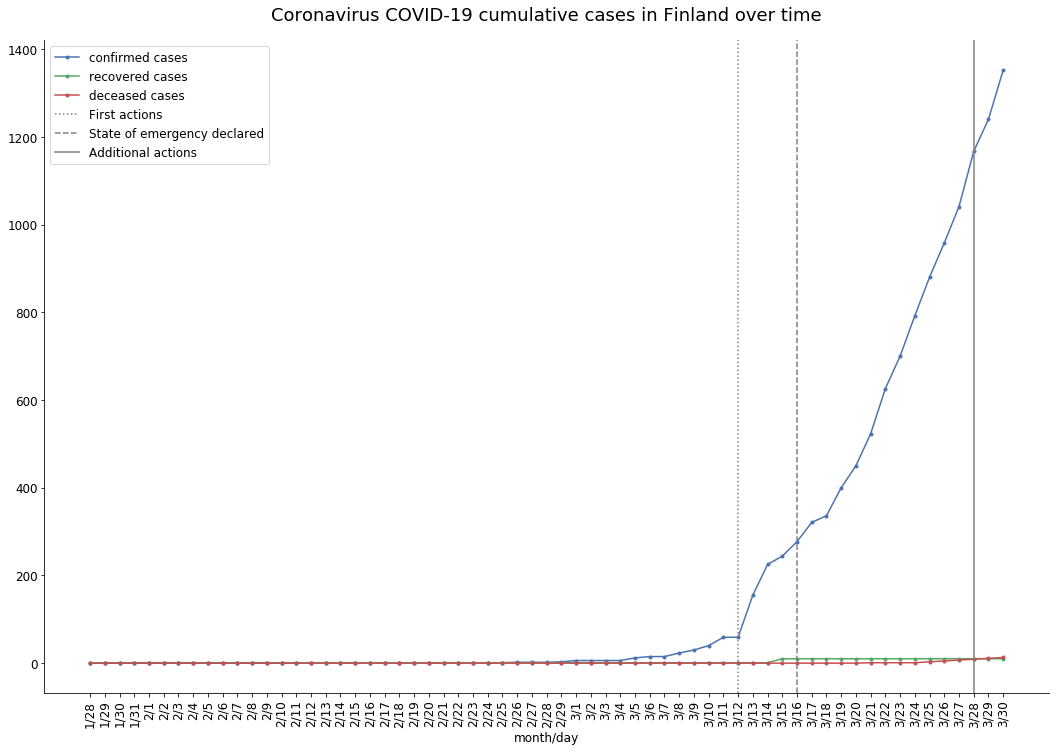

In [65]:
# Plotting daily cumulative cases in Finland
cust_line_plot((days_fin, finland_conf_6, ".", '-', 0, "confirmed cases"),
               (days_fin, finland_recov_6, ".", '-', 2, "recovered cases"),
               (days_fin, finland_deceas_6, ".", '-', 3, "deceased cases"),
               #(days_fin, finland_act_6, ".", '-', 1, "active cases"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative cases in Finland over time",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12,
               first_line_x='3/12', first_line_l='First actions',
               second_line_x='3/16', second_line_l='State of emergency declared',
               third_line_x='3/28', third_line_l='Additional actions')

In [66]:
print("Concrete actions by the Finnish government")
measures.style.hide_index()

Concrete actions by the Finnish government


Date,Actions
12.3.,First measures: gathering of more than 500 people banned
16.3.,"State of emergency declared: closing shools, universities, museums, theatres, libraries, sport facilities; gathering of more than 10 people banned"
28.3.,"Additional measures: Uusimaa region borders closed, restaurant dining forbidden"


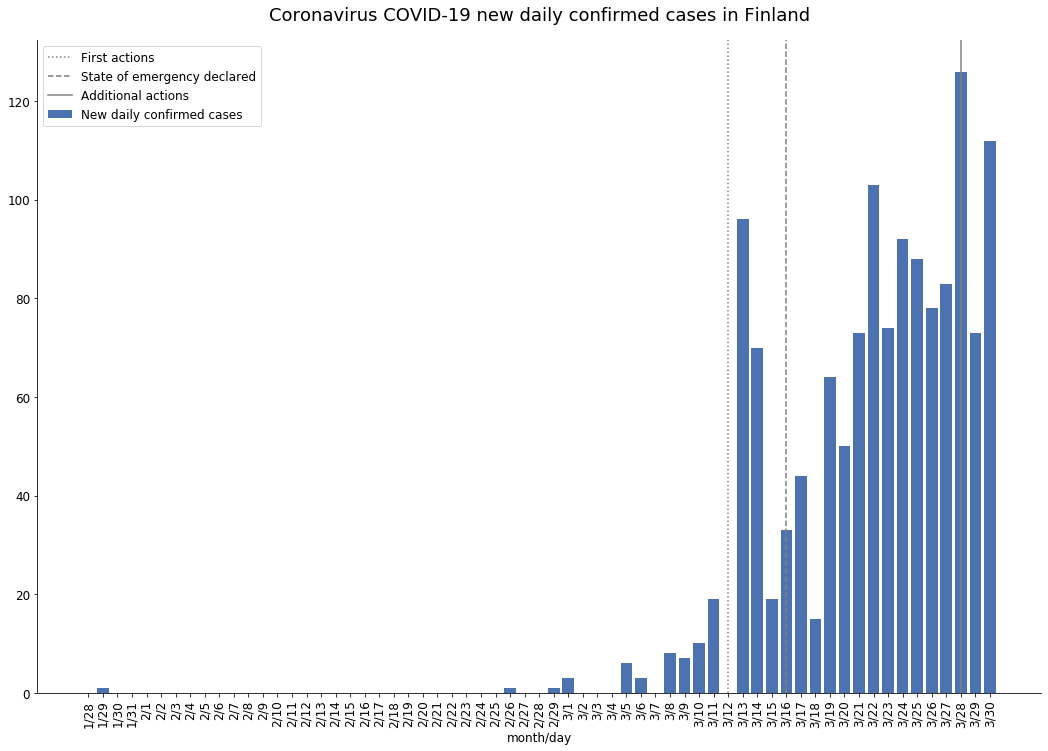

In [67]:
# Plotting new daily confirmed Coronavirus cases in Finland
cust_bar_plot((days_fin, finland_conf_incr_6, 0, "New daily confirmed cases"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 new daily confirmed cases in Finland",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12,
               first_line_x='3/12', first_line_l='First actions',
               second_line_x='3/16', second_line_l='State of emergency declared',
               third_line_x='3/28', third_line_l='Additional actions')

### 7.3. Comparison with Other Scandinavian Countries <a name="7.3."></a>

**Description of the plots of this section**

It appears that the Finnish curve is quite smooth compared to the other curces. Only Iceland has a smoother curve. This would suggest that the virus is not spreading faster in Finland compared to mosy of the other Scandinavian Countries. By shifting all the curves so that they start for each Country in the day of the first confirmed case, the Finnish curve is the slowest to grow. See also the note below.

Even though the virus started later in Finland, the first recovered case happened much earlier than the other Scandinavian Countries. However, the biggest number of recovered cases is in Sweden.

Finland has also the lowest number of deceased cases (Sweden has the highest).

**NOTE:** It should be noted that the testing policy in each Country affects considerably the way the curve looks like. The less people you test, the better the curve looks like.

**NOTE:** The data from Denmark does not include Faroe Islands and Greenland.

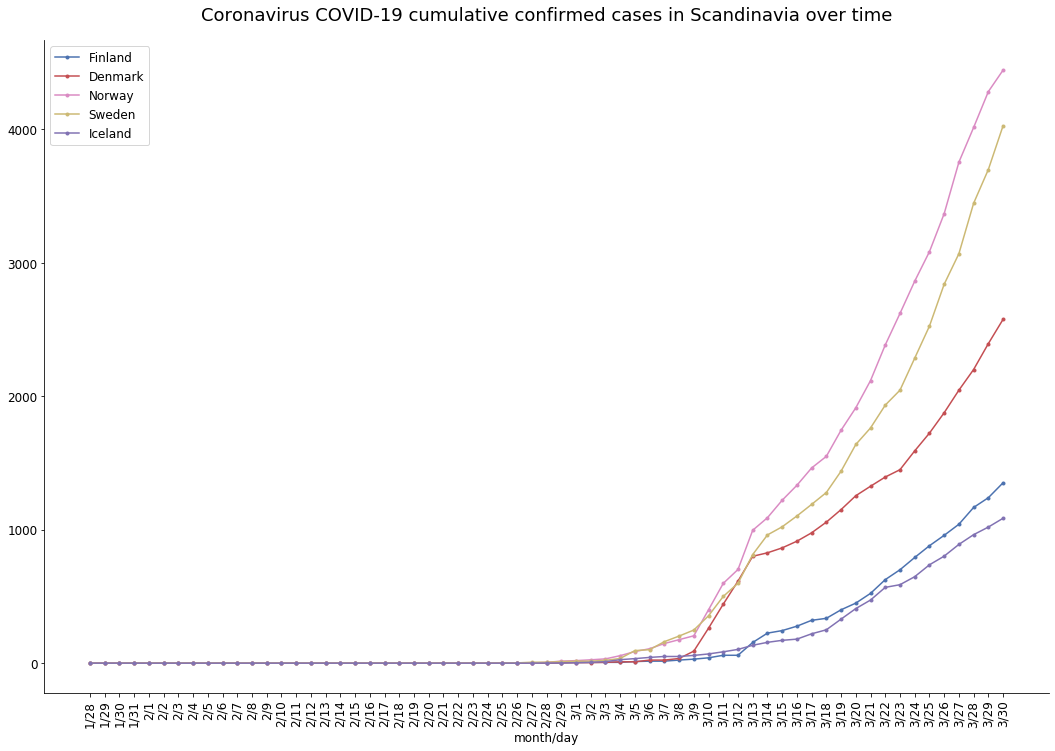

In [68]:
# Comparing cumulative confirmed cases over time in Scandinavia
cust_line_plot((days_fin, finland_conf_6, ".", '-', 0, "Finland"),
               (days_fin, denmark_conf_6, ".", '-', 3, "Denmark"),
               (days_fin, norway_conf_6, ".", '-', 6, "Norway"),
               (days_fin, sweden_conf_6, ".", '-', 8, "Sweden"),
               (days_fin, iceland_conf_6, ".", '-', 4, "Iceland"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases in "\
                     "Scandinavia over time",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

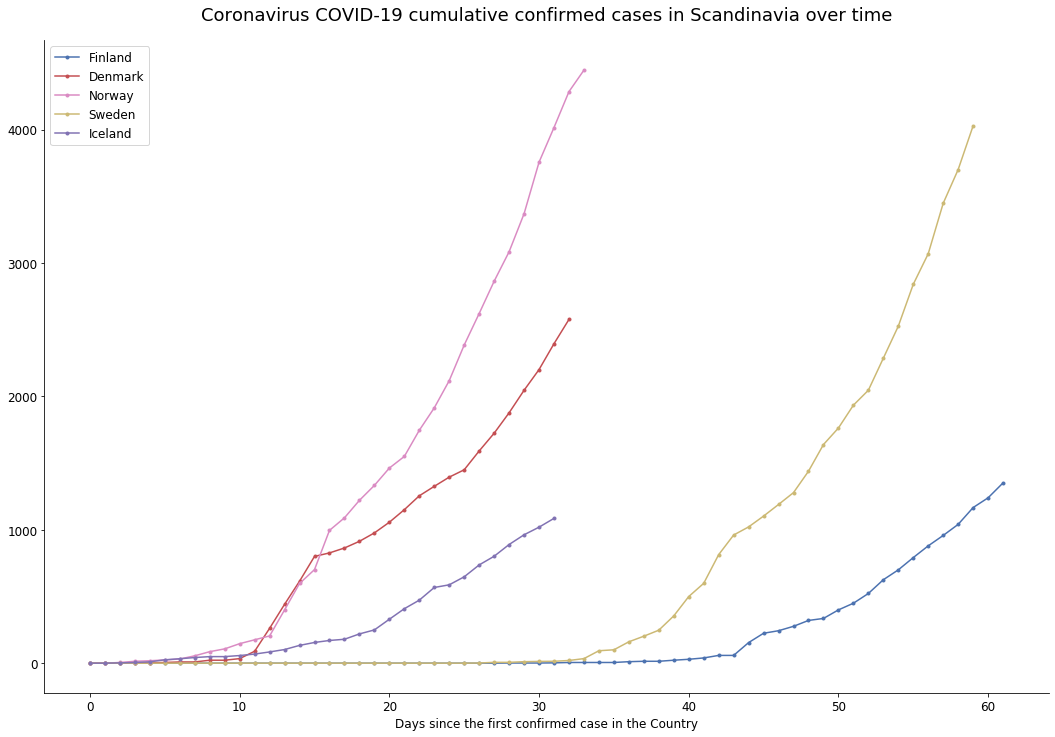

In [69]:
# Comparing cumulative confirmed cases over time in Scandinavia
# starting form the day of the first confirmed case
cust_line_plot((list(range(len(finland_conf_pos))), finland_conf_pos,
                ".", '-', 0, "Finland"),
               (list(range(len(denmark_conf_pos))), denmark_conf_pos,
                ".", '-', 3, "Denmark"),
               (list(range(len(norway_conf_pos))), norway_conf_pos,
                ".", '-', 6, "Norway"),
               (list(range(len(sweden_conf_pos))), sweden_conf_pos,
                ".", '-', 8, "Sweden"),
               (list(range(len(iceland_conf_pos))), iceland_conf_pos,
                ".", '-', 4, "Iceland"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases "\
                     "in Scandinavia over time",
               title_fs=18, title_offset=20,
               rem_borders=True, 
               label_fs=12, tick_fs=12, 
               x_label="Days since the first confirmed case in the Country",
               rot=0,
               y_label=None,
               legend=True,
               leg_fs=12)

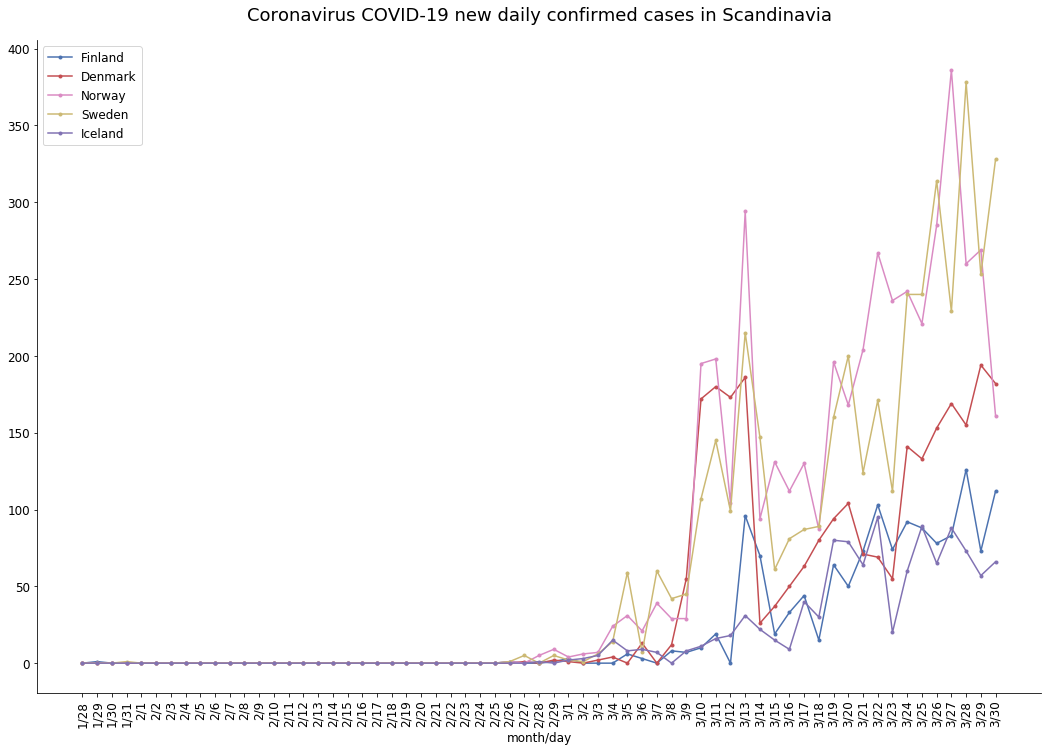

In [70]:
# Comparing new daily confirmed Coronavirus cases in Scandinavia
cust_line_plot((days_fin, finland_conf_incr_6, ".", '-', 0, "Finland"),
               (days_fin, denmark_conf_incr_6, ".", '-', 3, "Denmark"),
               (days_fin, norway_conf_incr_6, ".", '-', 6, "Norway"),
               (days_fin, sweden_conf_incr_6, ".", '-', 8, "Sweden"),
               (days_fin, iceland_conf_incr_6, ".", '-', 4, "Iceland"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 new daily confirmed cases "\
                     "in Scandinavia",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

**Comments to the next two plots:**

Data related to Iceland is corrupted (cumulative data cannot decrease) so the related plot is not shown.

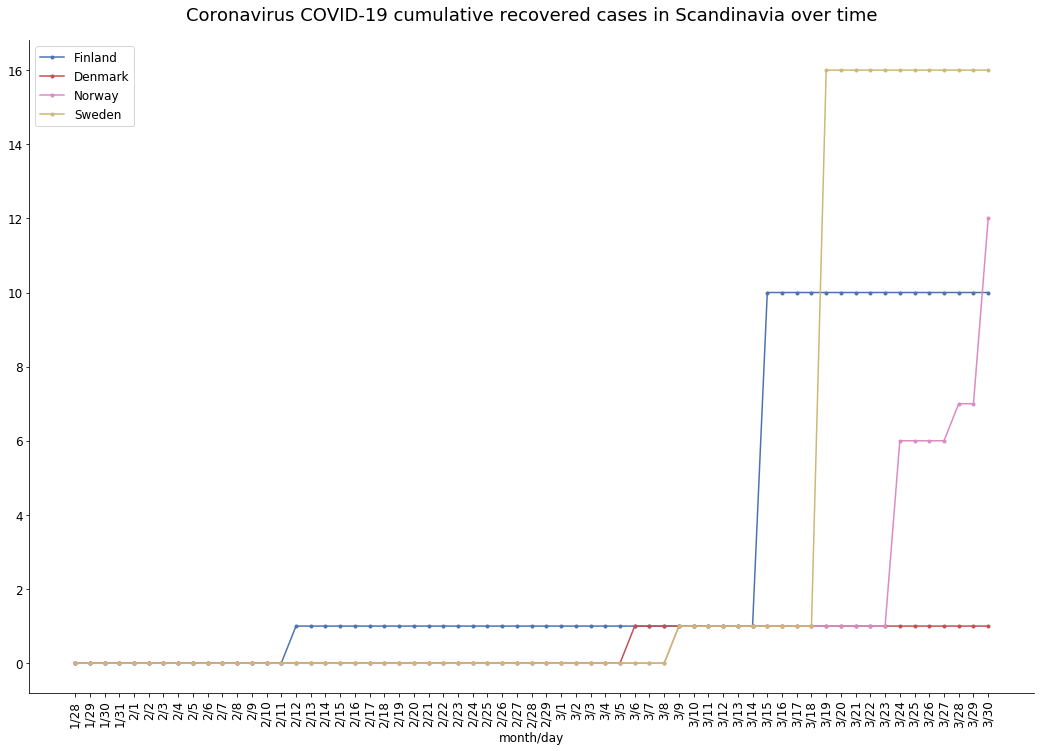

In [71]:
# Comparing cumulative recovered cases over time in Scandinavia
cust_line_plot((days_fin, finland_recov_6, ".", '-', 0, "Finland"),
               (days_fin, denmark_recov_6, ".", '-', 3, "Denmark"),
               (days_fin, norway_recov_6, ".", '-', 6, "Norway"),
               (days_fin, sweden_recov_6, ".", '-', 8, "Sweden"),
               #(days_fin, iceland_deceas_6, ".", '-', 4, "Iceland"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative recovered cases in "\
                     "Scandinavia over time",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

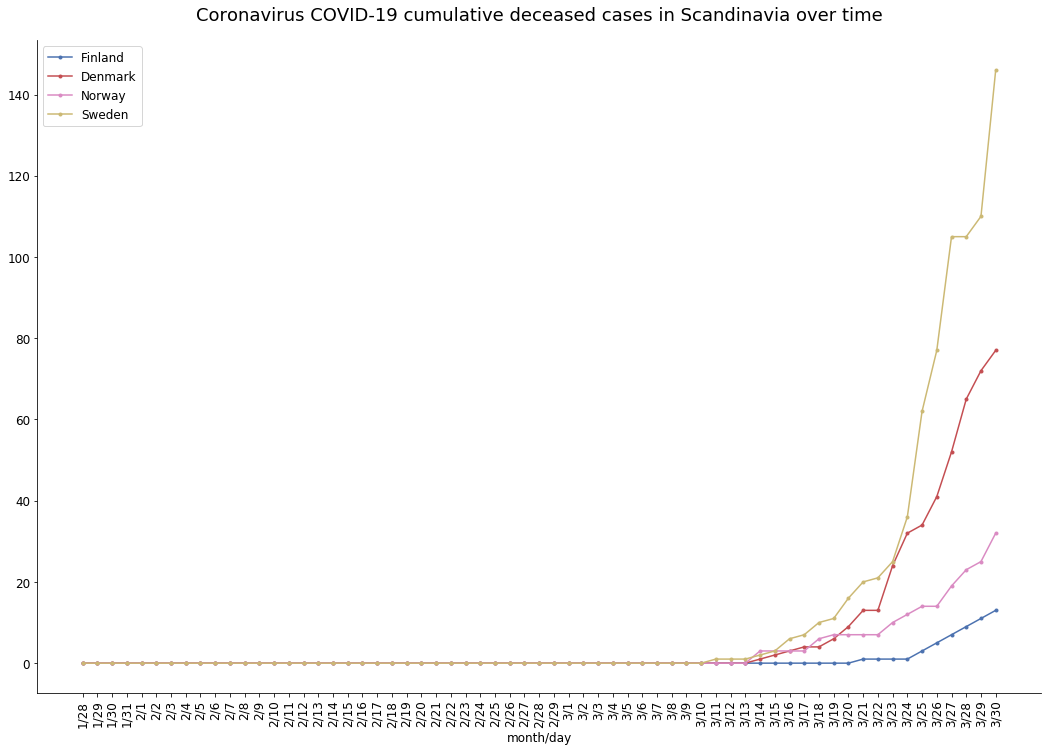

In [72]:
# Comparing cumulative deceased cases over time in Scandinavia
cust_line_plot((days_fin, finland_deceas_6, ".", '-', 0, "Finland"),
               (days_fin, denmark_deceas_6, ".", '-', 3, "Denmark"),
               (days_fin, norway_deceas_6, ".", '-', 6, "Norway"),
               (days_fin, sweden_deceas_6, ".", '-', 8, "Sweden"),
               #(days_fin, iceland_deceas_6, ".", '-', 4, "Iceland"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative deceased cases in "\
                     "Scandinavia over time",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

### 7.4. Comparison with Italy and other European Countries<a name="7.4."></a>

**Comment to the plots in this section**

Finland has also the lowest curves compared to other European Countries.

The plots related to the new confirmed cases show the same pattern for all those Countries. This might be due to the fact that those plots are very much dependent on how many people are tested in a certain day.

**NOTE:** When comparing those curves please note also that the testing policy in each Country affects considerably the way the curve looks like. The less people you test, the better the curve looks like.

**NOTE:** The data from France and Netherlands does not include offshore territories.

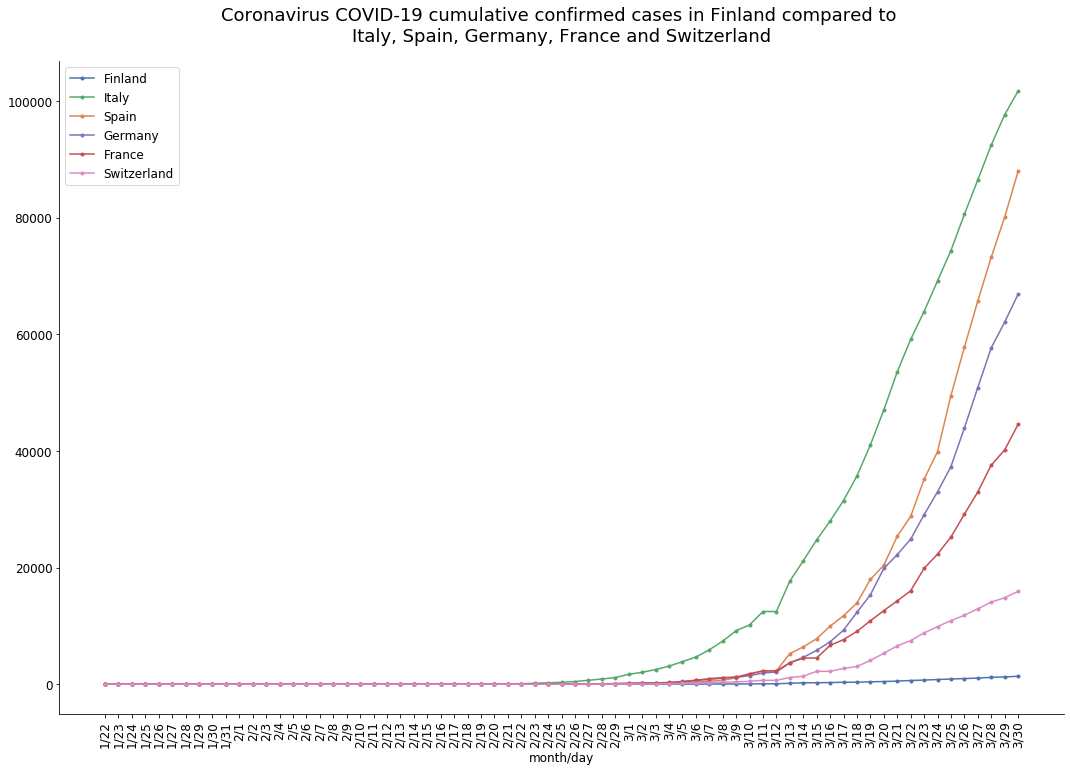

In [73]:
# Comparing cumulative confirmed cases over time for Finland,
# Italy, Spain, Germany, France and Switzerland
cust_line_plot((days_tot, finland_conf_0, ".", '-', 0, "Finland"),
               (days_tot, italy_conf_0, ".", '-', 2, "Italy"),
               (days_tot, spain_conf_0, ".", '-', 1, "Spain"),
               (days_tot, germany_conf_0, ".", '-', 4, "Germany"),
               (days_tot, france_conf_0, ".", '-', 3, "France"),              
               (days_tot, switzerland_conf_0, ".", '-', 6, "Switzerland"),            
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases "\
                     "in Finland compared to \nItaly, Spain, Germany, France and Switzerland",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

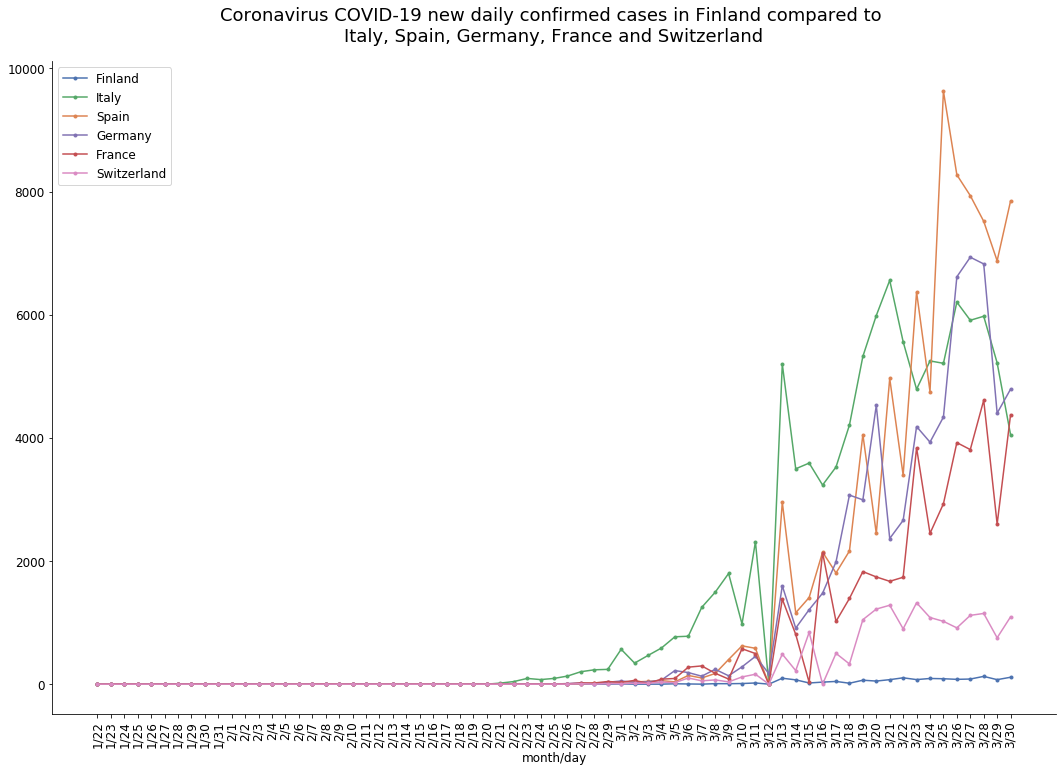

In [74]:
# Comparing new daily confirmed cases over time for Finland,
# Italy, Spain, Germany, France and Switzerland
cust_line_plot((days_tot, finland_conf_incr_0, ".", '-', 0, "Finland"),
               (days_tot, italy_conf_incr_0, ".", '-', 2, "Italy"),
               (days_tot, spain_conf_incr_0, ".", '-', 1, "Spain"),
               (days_tot, germany_conf_incr_0, ".", '-', 4, "Germany"),
               (days_tot, france_conf_incr_0, ".", '-', 3, "France"),
               (days_tot, switzerland_conf_incr_0, ".", '-', 6, "Switzerland"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 new daily confirmed cases "\
                     "in Finland compared to \nItaly, Spain, Germany, France and Switzerland",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

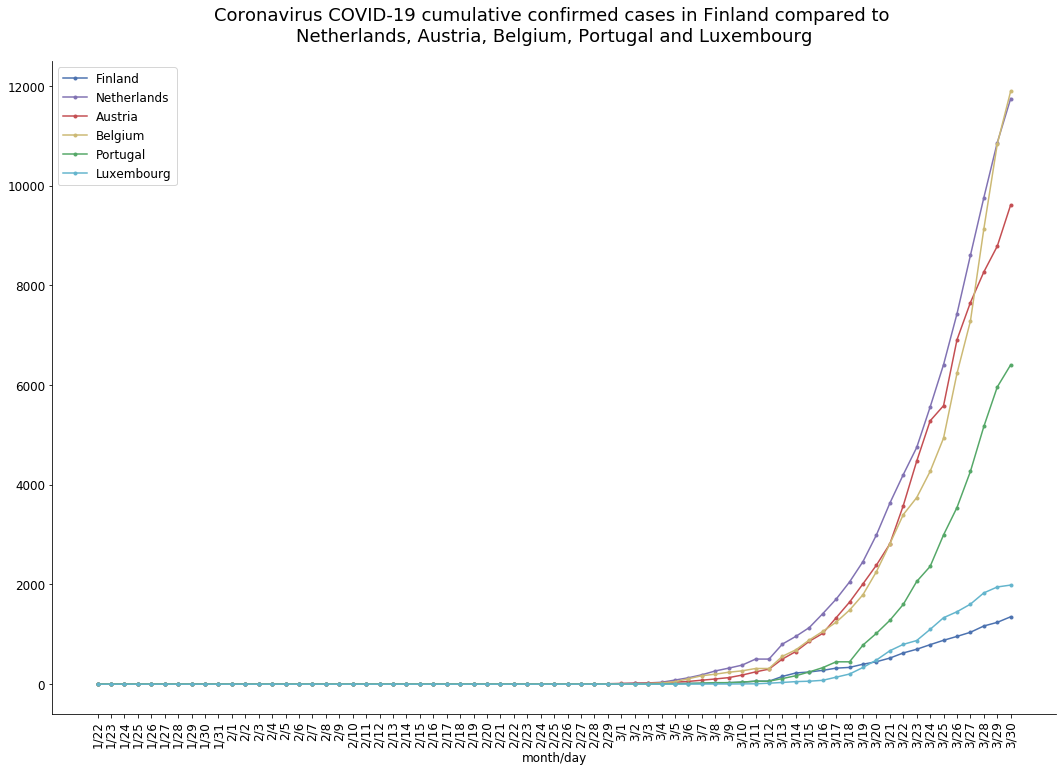

In [75]:
# Comparing cumulative confirmed cases over time for Finland,
# Netherlands, Austria, Belgium, Portugal and Luxembourg
cust_line_plot((days_tot, finland_conf_0, ".", '-', 0, "Finland"),               
               (days_tot, netherlands_conf_0, ".", '-', 4, "Netherlands"),
               (days_tot, austria_conf_0, ".", '-', 3, "Austria"),
               (days_tot, belgium_conf_0, ".", '-', 8, "Belgium"),
               (days_tot, portugal_conf_0, ".", '-', 2, "Portugal"),
               (days_tot, luxembourg_conf_0, ".", '-', 9, "Luxembourg"),              
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases "\
                     "in Finland compared to \nNetherlands, Austria, "\
                     "Belgium, Portugal and Luxembourg",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

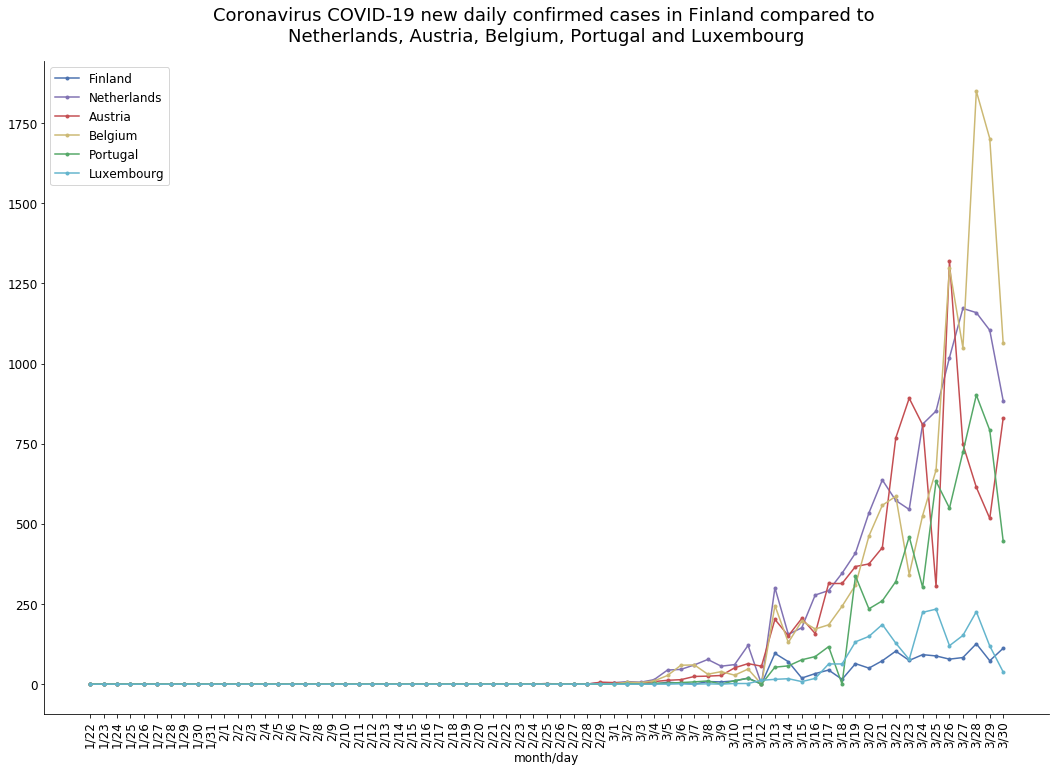

In [76]:
# Comparing new daily confirmed cases for Finland,
# Switzerland, Netherlands, Austria and Belgium
cust_line_plot((days_tot, finland_conf_incr_0, ".", '-', 0, "Finland"),             
               (days_tot, netherlands_conf_incr_0, ".", '-', 4, "Netherlands"),
               (days_tot, austria_conf_incr_0, ".", '-', 3, "Austria"),
               (days_tot, belgium_conf_incr_0, ".", '-', 8, "Belgium"),
               (days_tot, portugal_conf_incr_0, ".", '-', 2, "Portugal"),               
               (days_tot, luxembourg_conf_incr_0, ".", '-', 9, "Luxembourg"),         
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 new daily confirmed cases "\
                     "in Finland compared to \nNetherlands, Austria, "\
                     "Belgium, Portugal and Luxembourg",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

### 7.5. Comparison with UK and US<a name="7.5."></a>

**Comment to the plots in this section**

UK and US have followed quite relaxed policies in containing the spread of the virus during the first days.

**NOTE:** The data from UK does not include the Isle of Man and the Channel Islands.

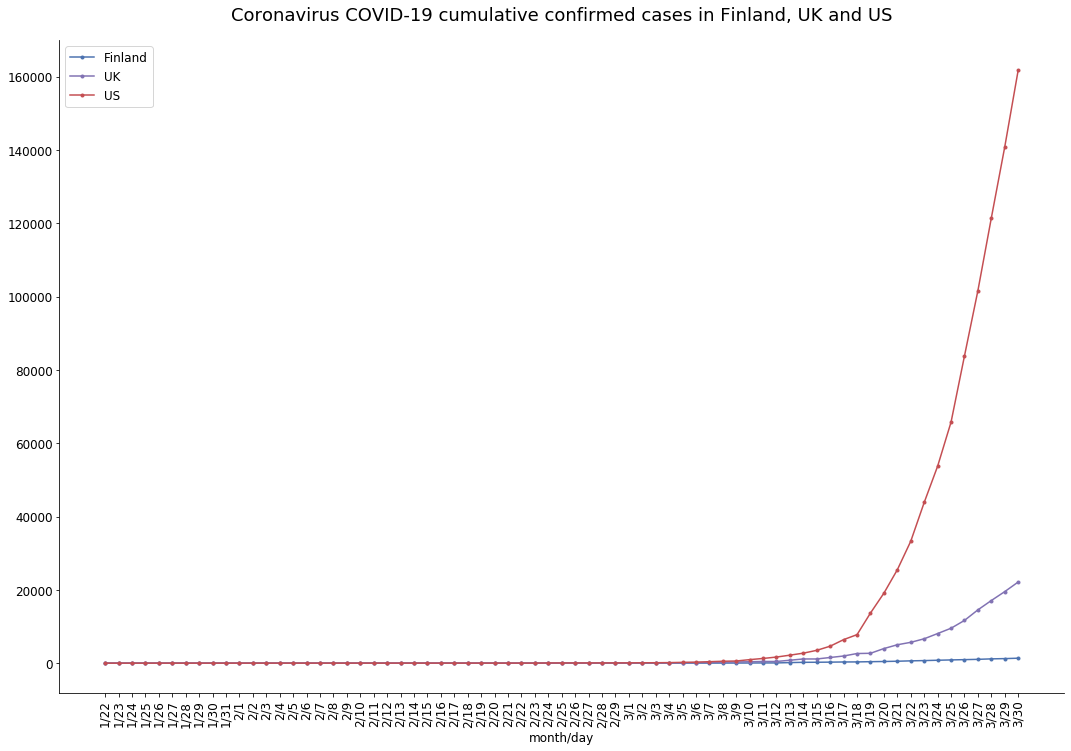

In [77]:
# Comparing cumulative confirmed Coronavirus cases in Finland, UK and US
cust_line_plot((days_tot, finland_conf_0, ".", '-', 0, "Finland"),
               (days_tot, uk_conf_0, ".", '-', 4, "UK"),
               (days_tot, us_conf_0, ".", '-', 3, "US"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases "\
                     "in Finland, UK and US",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

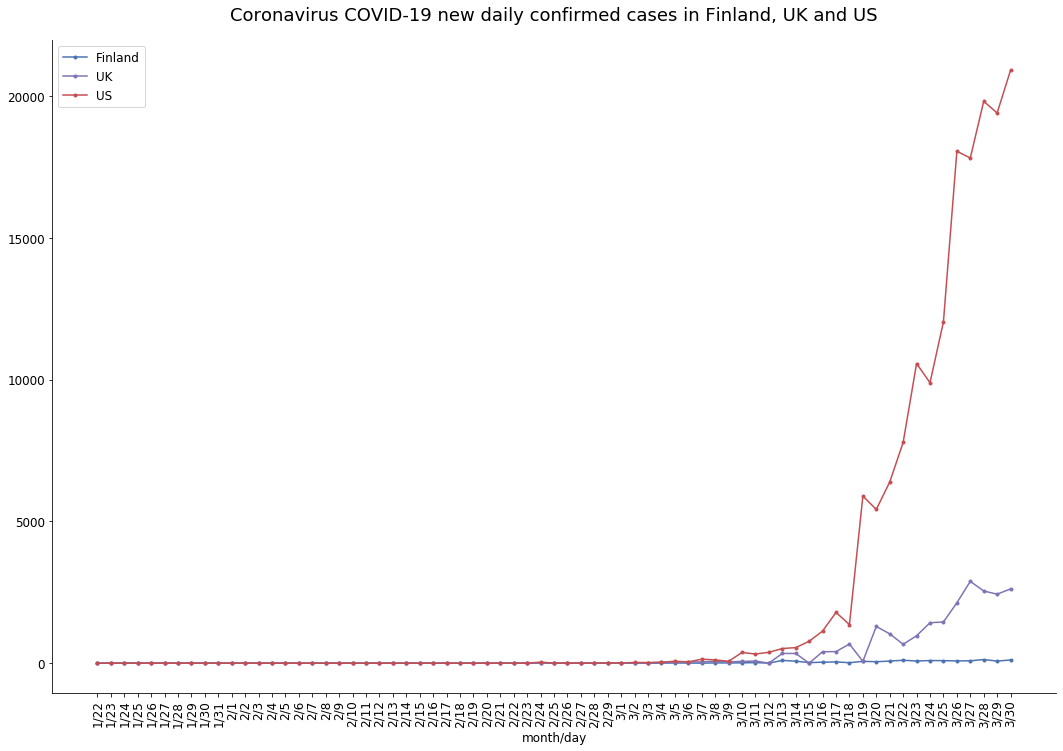

In [78]:
# Comparing new daily confirmed cases Coronavirus cases in Finland, UK and US
cust_line_plot((days_tot, finland_conf_incr_0, ".", '-', 0, "Finland"),
               (days_tot, uk_conf_incr_0, ".", '-', 4, "UK"),
               (days_tot, us_conf_incr_0, ".", '-', 3, "US"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 new daily confirmed cases "\
                     "in Finland, UK and US",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

### 7.6. Normalizing by Country population <a name="7.6."></a>

**Comments to the plots in this section**

The curves related to the cumulative confirmed cases seem to have the same shape. The main difference seems to be the height.

The height of those curves can differ for different reasons, including:

- the Country overall population (obviously the more people are in the Country, the more people can get infected)
- the population density (higher is the population density, easier it might be for the virus to spread)
- demographics (older is the population, easier is for the virus to hit)
- genetics ?
- climate (the virus might have more difficulty to survive in too cold or too hot weather)
- the testing policy in the Country (the more people a Country tests, the more infected cases might be discovered)
- which containment measures have been taken by Authorities and how early
- how well the population has followed the containment measures
- whether the Country is in a central area and whether there is a lot of movement of people
- last but not least, the stage in which the Country is (the curves follow all the same smooth-steep-smooth shape so Countries where the virus has just started to spread show lower curves)

It might be interesting to isolate the first variable, Country population, by dividing the values by the Country population in order to calculate the amount of cases per capita. The result is shown in the first plot. The plot shows that the other variables still can affect the curve as much as 10 times.

NOTE: The Country population figures are approximative.

In [79]:
print("The range of the median age in the Countries that are analyzed here is: "\
      "{:.1f} years"\
     .format(median_age_range))

The range of the median age in the Countries that are analyzed here is: 9.0 years


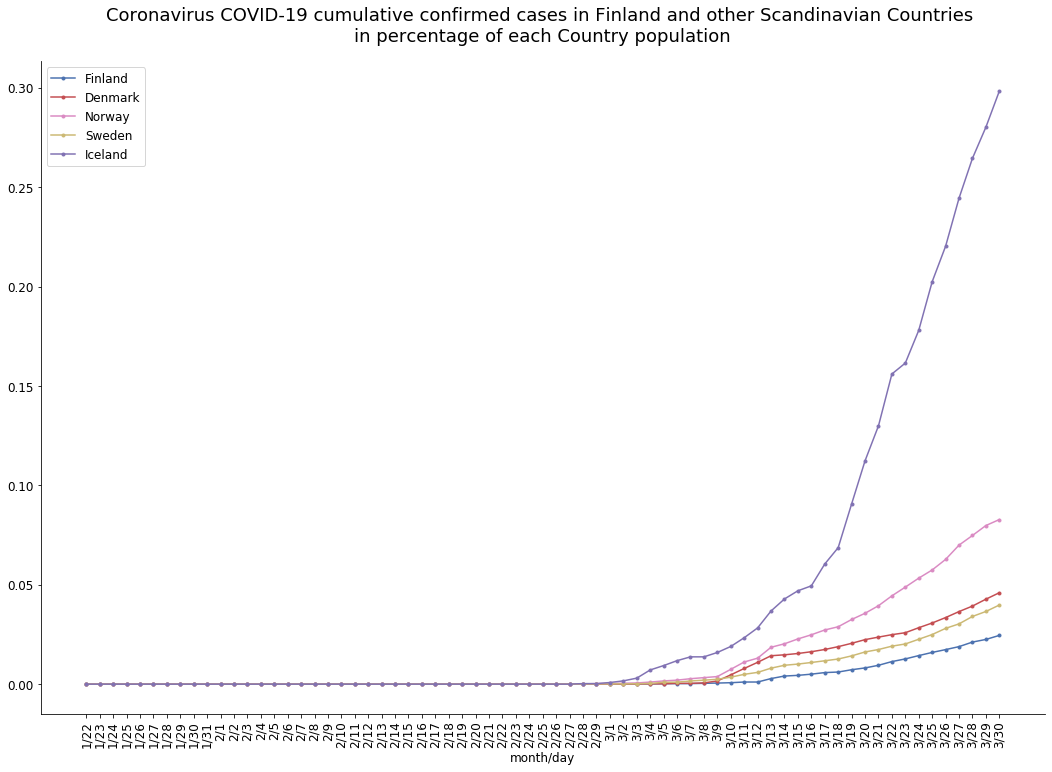

In [80]:
# Comparing cumulative confirmed cases over time for Finland,
# and other Scandinavian Countries in percentage of the Country population
cust_line_plot((days_tot, finland_conf_0_perc, ".", '-', 0, "Finland"),
               (days_tot, denmark_conf_0_perc, ".", '-', 3, "Denmark"),
               (days_tot, norway_conf_0_perc, ".", '-', 6, "Norway"),
               (days_tot, sweden_conf_0_perc, ".", '-', 8, "Sweden"),
               (days_tot, iceland_conf_0_perc, ".", '-', 4, "Iceland"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases "\
                     "in Finland and other Scandinavian Countries \n"\
                     "in percentage of each Country population",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

**Comments to the plot above**

Finland has the lowest number of confirmed cases per capita. Iceland has the highest number.

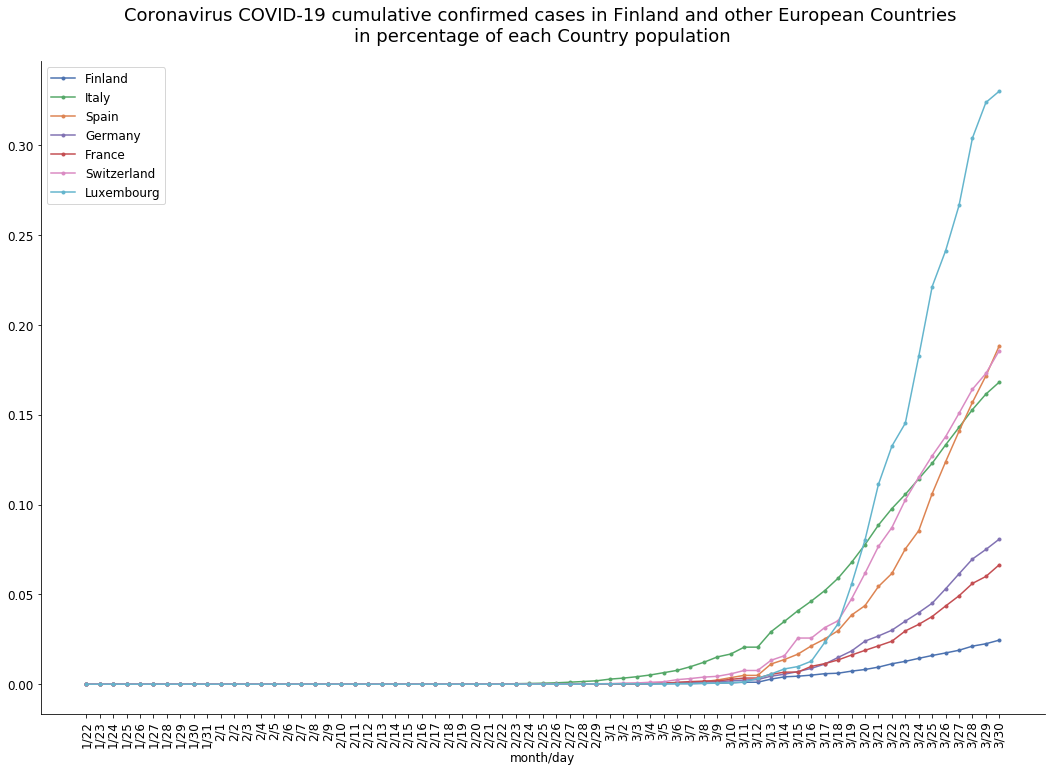

In [81]:
# Comparing cumulative confirmed cases over time for Finland,
# and other European Countries in percentage of the Country population
cust_line_plot((days_tot, finland_conf_0_perc, ".", '-', 0, "Finland"),
               (days_tot, italy_conf_0_perc, ".", '-', 2, "Italy"),
               (days_tot, spain_conf_0_perc, ".", '-', 1, "Spain"),
               (days_tot, germany_conf_0_perc, ".", '-', 4, "Germany"),
               (days_tot, france_conf_0_perc, ".", '-', 3, "France"),
               (days_tot, switzerland_conf_0_perc, ".", '-', 6, "Switzerland"),
               (days_tot, luxembourg_conf_0_perc, ".", '-', 9, "Luxembourg"), 
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases "\
                     "in Finland and other European Countries \n"\
                     "in percentage of each Country population",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

**Comments to the plot above**

Luxembourg has the a higher number of confirmed cases per capita than Iceland.

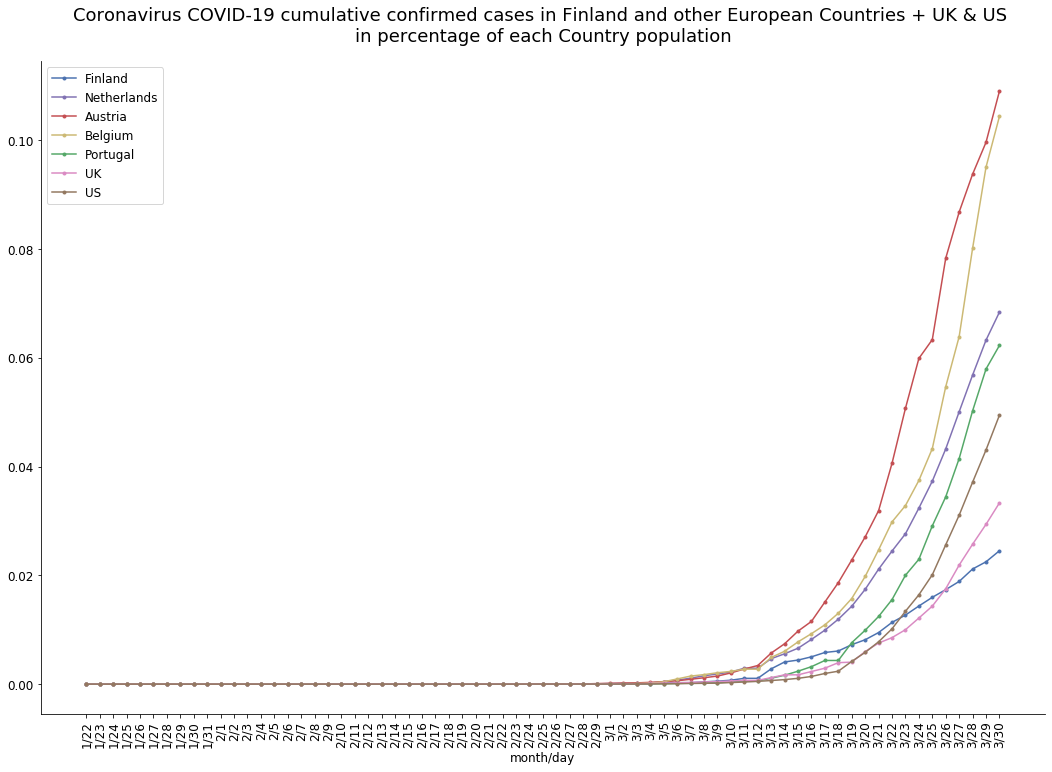

In [82]:
# Comparing cumulative confirmed cases over time for Finland,
# and other European Countries + UK & US in percentage of the Country population
cust_line_plot((days_tot, finland_conf_0_perc, ".", '-', 0, "Finland"),
               (days_tot, netherlands_conf_0_perc, ".", '-', 4, "Netherlands"),
               (days_tot, austria_conf_0_perc, ".", '-', 3, "Austria"),
               (days_tot, belgium_conf_0_perc, ".", '-', 8, "Belgium"),
               (days_tot, portugal_conf_0_perc, ".", '-', 2, "Portugal"),
               (days_tot, uk_conf_0_perc, ".", '-', 6, "UK"),
               (days_tot, us_conf_0_perc, ".", '-', 5, "US"),               
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases "\
                     "in Finland and other European Countries + UK & US \n"\
                     "in percentage of each Country population",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

**Comments to the plot**

Note that one of the reasons why UK and Finland curves started pretty low might be due to the fact that they are quite isolated geographically and therefore the virus started to spread later.

However, those curves clearly show that in Countries that have not taken prompt containment actions, as UK and US, those curves started to take a steeper shape.

### 7.7. Situation in China <a name="7.7."></a>

**Comments to the plot**

The first plot shows that the shape of the cumulative curves for the two areas in the Country are very similar. The main visible difference is the amplitude of the curves.

It happears that the number of confirmed cases in China outside Hubei province shows a tendency to grow again.

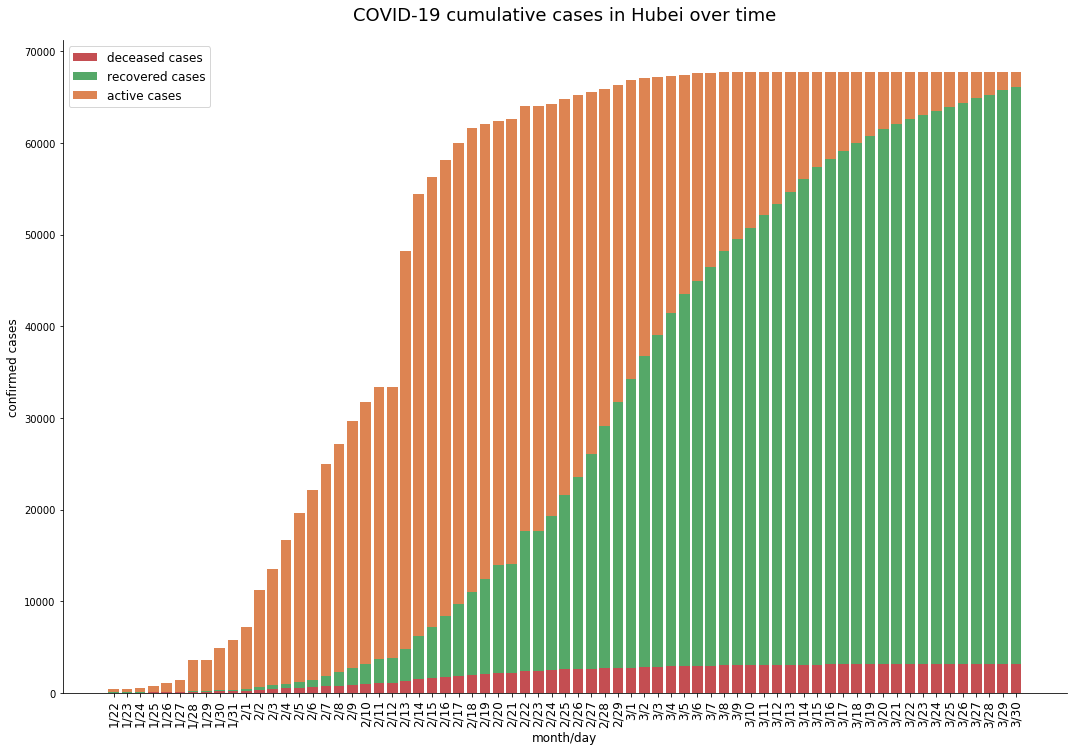

In [83]:
# Plotting daily cumulative cases in Hubei
plot_stacked_bar(days_tot,
                 [hubei_deceas_0, hubei_recov_0, hubei_act_0],
                 ["deceased cases", "recovered cases", "active cases"],
                 col=[3, 2, 1],
                 multidim=True, figsize_w=18, figsize_h=12,
                 title="COVID-19 cumulative cases in Hubei over time",
                 title_fs=18,
                 frame=False,
                 category_labels=days_tot,
                 label_fs = 12, ticks_fs=12, 
                 x_label="month/day", rot=90,
                 y_label="confirmed cases",
                 legend=True, legend_loc = 2, legend_fs=12,
                 add_text=None, addtext_x=0, addtext_y=0, addtext_fs=10)

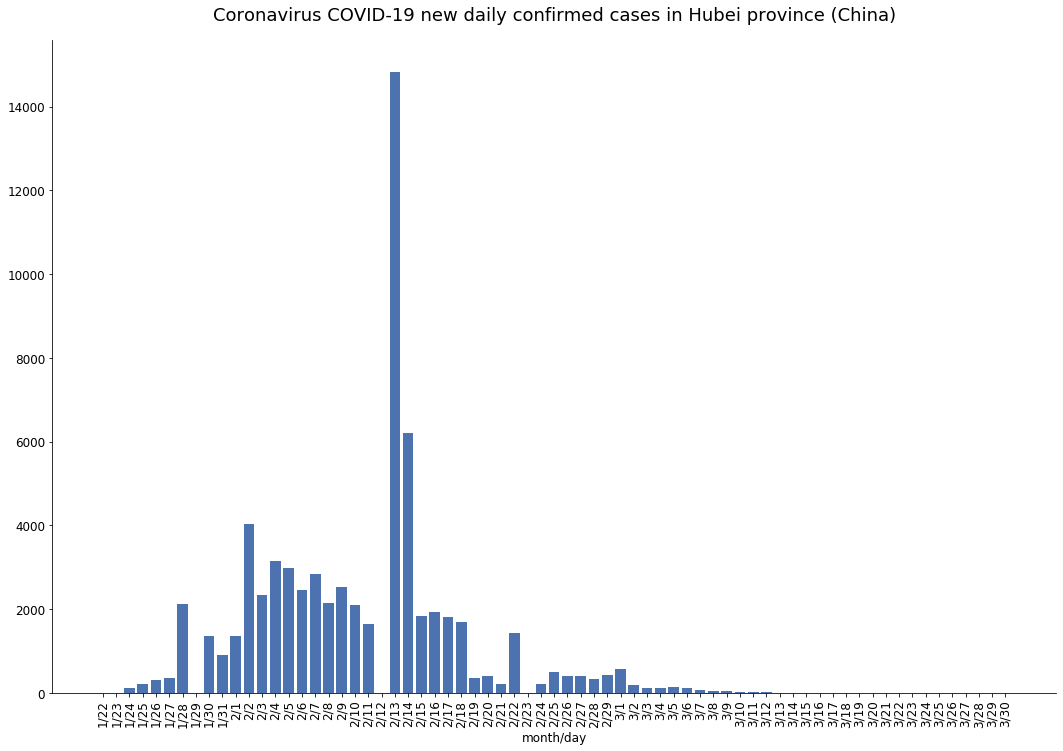

In [84]:
# Plotting daily increments in confirmed cases in Hubei province in China
cust_bar_plot((days_tot, hubei_conf_incr_0, 0, ""),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 new daily confirmed cases in Hubei province (China)",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=False,
               leg_fs=12)

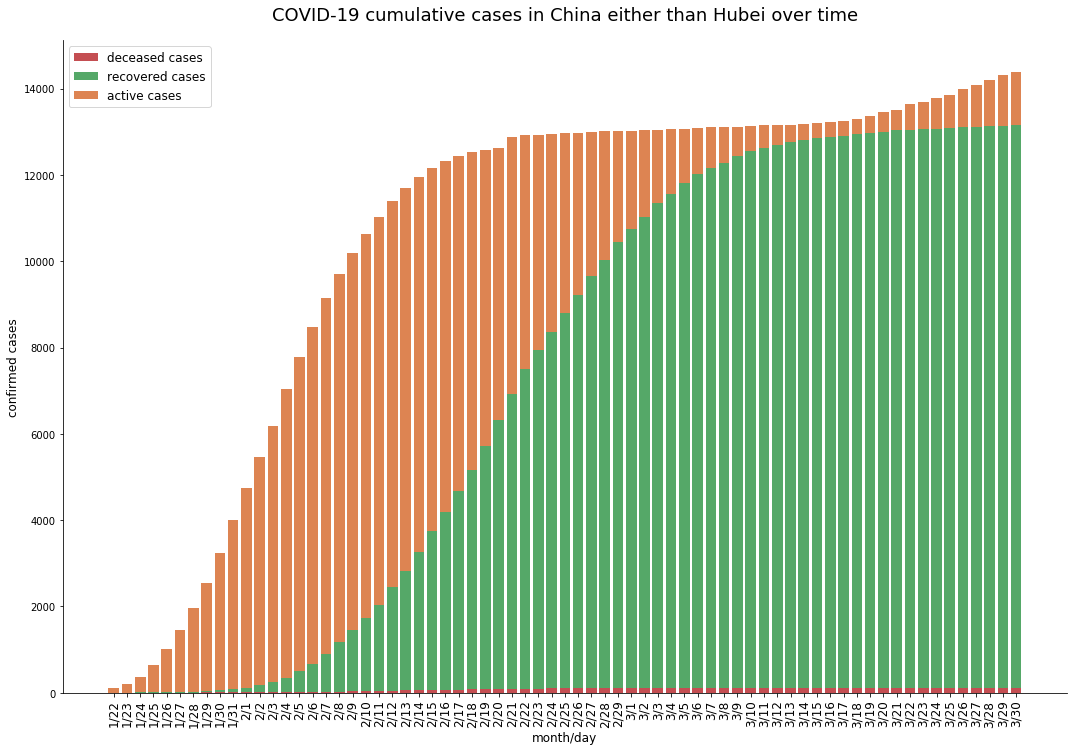

In [85]:
# Plotting daily cumulative cases in the rest of China
plot_stacked_bar(days_tot,
                 [restchina_deceas_0, restchina_recov_0, restchina_act_0],
                 ["deceased cases", "recovered cases", "active cases"],
                 col=[3, 2, 1],
                 multidim=True, figsize_w=18, figsize_h=12,
                 title="COVID-19 cumulative cases in China either than Hubei over time",
                 title_fs=18,
                 frame=False,
                 category_labels=days_tot,
                 label_fs = 12, ticks_fs=12, 
                 x_label="month/day", rot=90,
                 y_label="confirmed cases",
                 legend=True, legend_loc = 2, legend_fs=12,
                 add_text=None, addtext_x=0, addtext_y=0, addtext_fs=10)

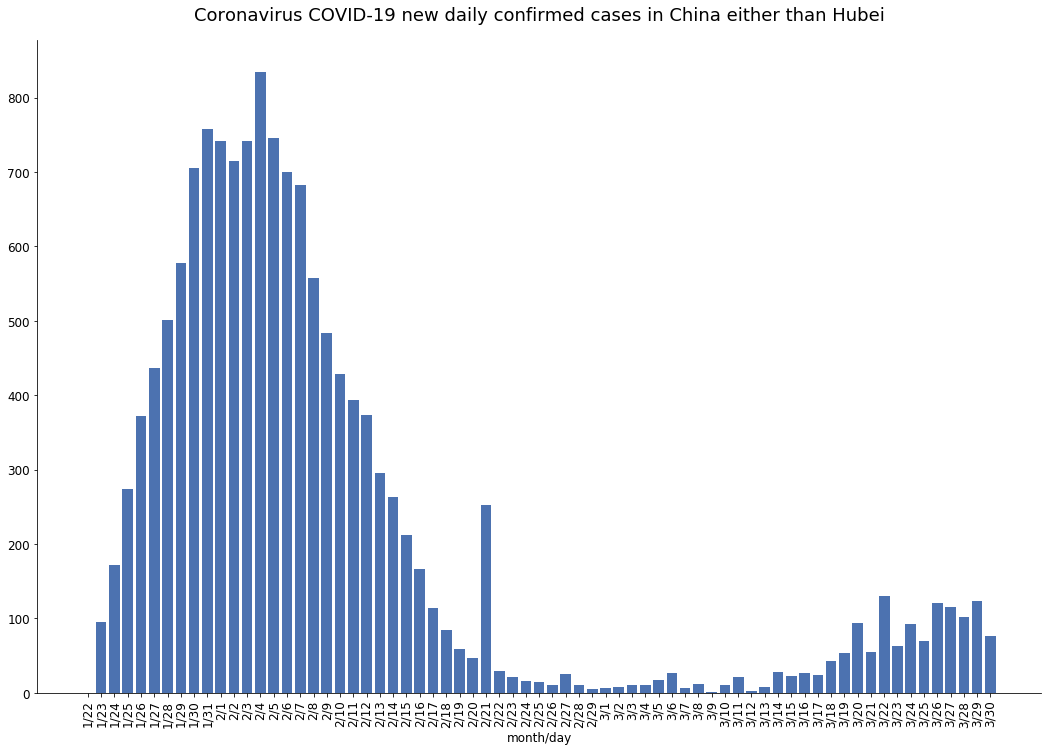

In [86]:
# Plotting daily increments in confirmed cases in the rest of China
cust_bar_plot((days_tot, restchina_conf_incr_0, 0, ""),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 new daily confirmed cases in China either than Hubei",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=False,
               leg_fs=12)

### 7.8. Situation in Italy <a name="7.8."></a>

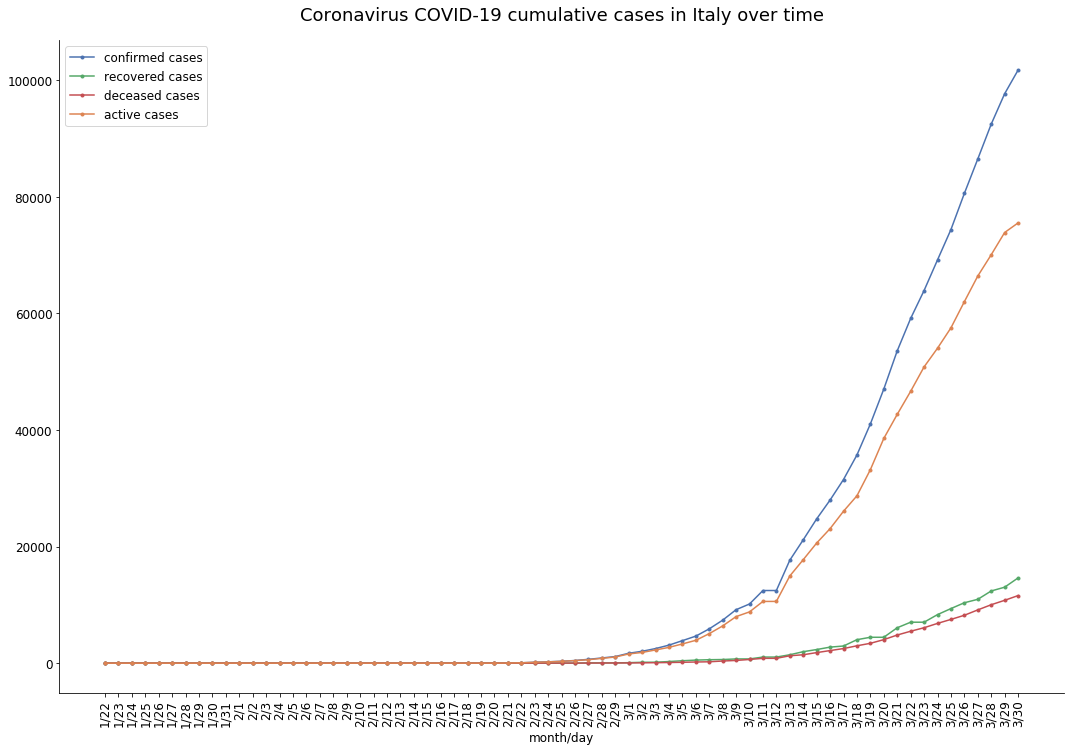

In [87]:
# Plotting daily cumulative cases in Italy
cust_line_plot((days_tot, italy_conf_0, ".", '-', 0, "confirmed cases"),
               (days_tot, italy_recov_0, ".", '-', 2, "recovered cases"),
               (days_tot, italy_deceas_0, ".", '-', 3, "deceased cases"),
               (days_tot, italy_act_0, ".", '-', 1, "active cases"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative cases in Italy over time",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

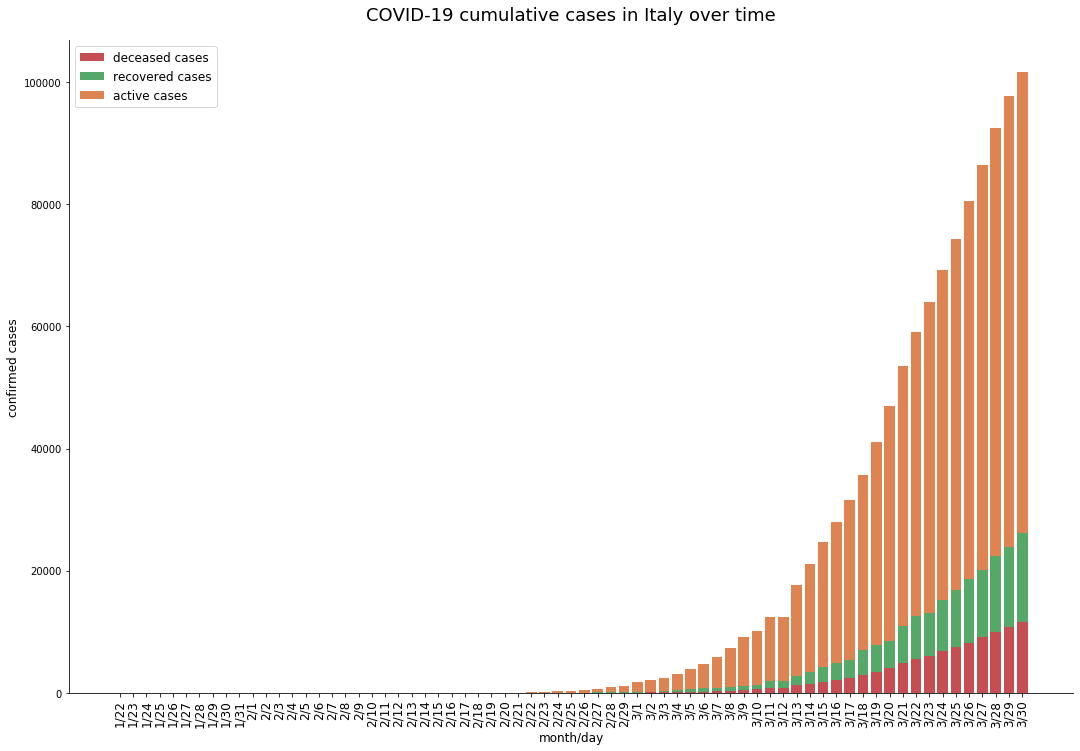

In [88]:
# Plotting daily cumulative cases in Italy
plot_stacked_bar(days_tot,
                 [italy_deceas_0, italy_recov_0, italy_act_0],
                 ["deceased cases", "recovered cases", "active cases"],
                 col=[3, 2, 1],
                 multidim=True, figsize_w=18, figsize_h=12,
                 title="COVID-19 cumulative cases in Italy over time",
                 title_fs=18,
                 frame=False,
                 category_labels=days_tot,
                 label_fs = 12, ticks_fs=12, 
                 x_label="month/day", rot=90,
                 y_label="confirmed cases",
                 legend=True, legend_loc = 2, legend_fs=12,
                 add_text=None, addtext_x=0, addtext_y=0, addtext_fs=10)

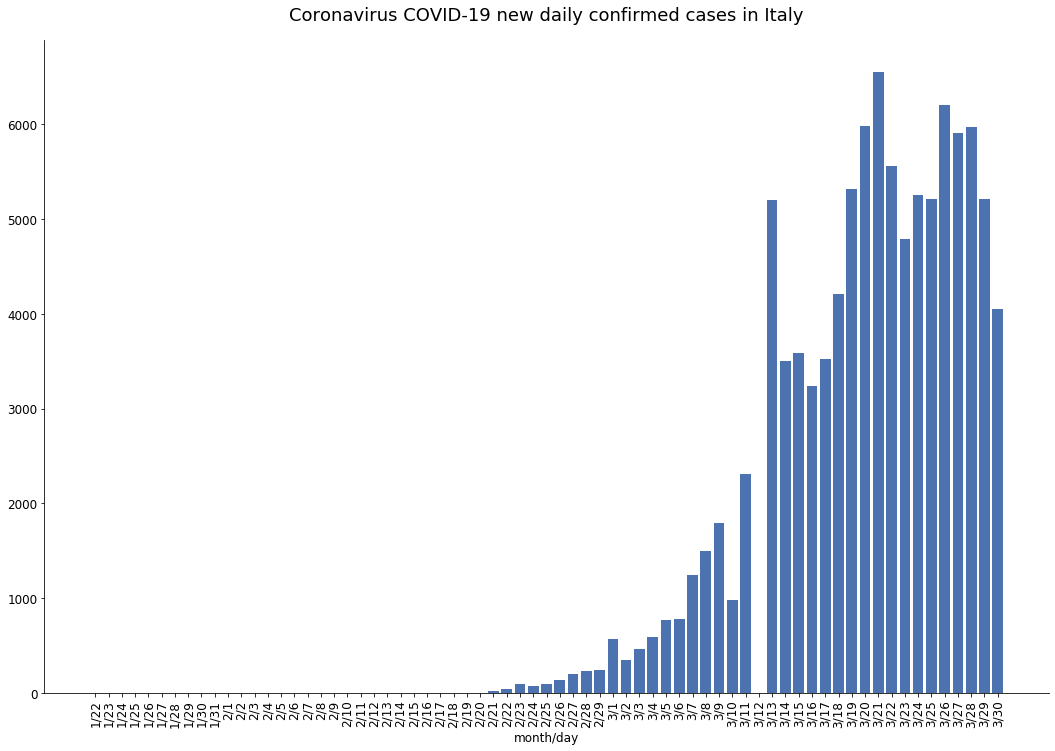

In [89]:
# Plotting new daily confirmed Coronavirus cases in Italy
cust_bar_plot((days_tot, italy_conf_incr_0, 0, ""),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 new daily confirmed cases in Italy",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=False,
               leg_fs=12)

### 7.9. World View<a name="7.9."></a>

**Comment to the plots**

March 30th.

It is interesting to compare the following two plots to the Chinese curves in order to get a grasp of how long the first wave of emergency might last in the all world. In order to do this, it is important to note that the Chinese curves do not start from a zero cumulative value. In other words, the Chinese curves are missing at least a good full month. Therefore, we can only compare the Chinese curves to the second half of the world curves.

It looks that the most recent half of the world curves corresponds to less than 1/4 of the expected length of the curve and it took a month to go through that part of the curve. So, everything else being equal, the first world-wide wave might last at least other 3 months. However, it shall be noted that there might be many variables affecting the development of the world curves and the value of those variables might differ from the Chinese ones.

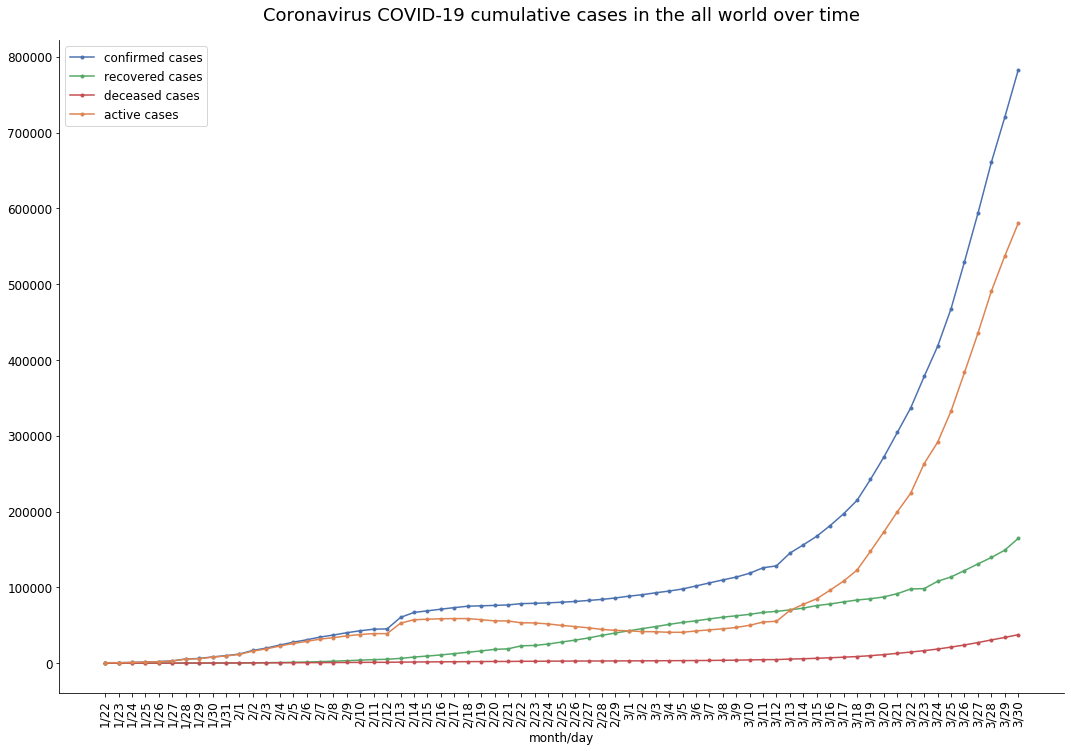

In [90]:
# Plotting daily cumulative cases in the all world
cust_line_plot((days_tot, world_conf_tot, ".", '-', 0, "confirmed cases"),
               (days_tot, world_recov_tot, ".", '-', 2, "recovered cases"),
               (days_tot, world_deceas_tot, ".", '-', 3, "deceased cases"),
               (days_tot, world_act_tot, ".", '-', 1, "active cases"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative cases in the all world "\
                     "over time",
               title_fs=18, title_offset=20,
               rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=True,
               leg_fs=12)

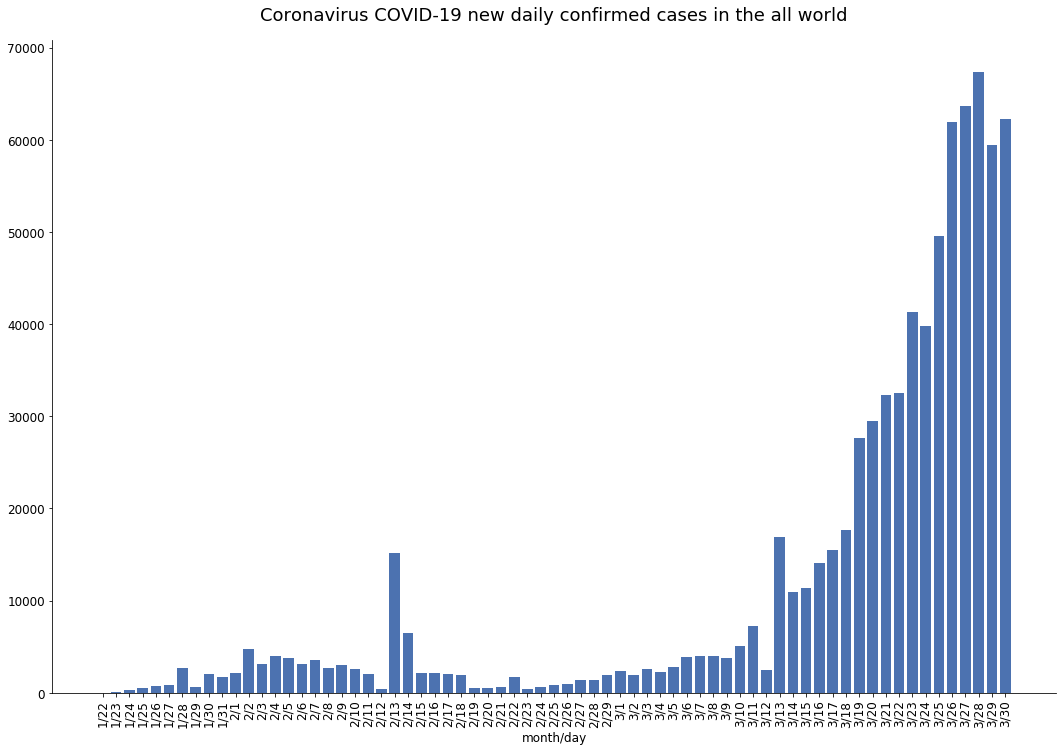

In [91]:
# Plotting new daily cases in the all world
cust_bar_plot((days_tot, world_conf_incr, 0, ""),
              figsize_w=18, figsize_h=12,
              title="Coronavirus COVID-19 new daily confirmed cases in the all world",
              title_fs=18, title_offset=20,
              rem_borders=True,
               label_fs=12, tick_fs=12, 
               x_label="month/day",
               rot=90,
               y_label=None,
               legend=False,
               leg_fs=12)

## 8. Statistics <a name="8."></a>

### 8.1. World View <a name="8.1."></a>

In [92]:
# Reordering the columns
daily_rep_group = daily_rep_group.reindex(columns=['Confirmed',
                                                   'Recovered',
                                                   'Deaths',
                                                   'Active'])

In [93]:
print("Grand Total Worldwide:\n")
print(daily_rep_group.sum().to_string())

Grand Total Worldwide:

Confirmed    782365
Recovered    164566
Deaths        37582
Active       420180


In [94]:
# Mortality (worldwide)
mort = (daily_rep_group.sum()[2]/daily_rep_group.sum()[0])*100
print("'Calculated' mortality worldwide: {:.2f}\n".format(mort))
print("IMPORTANT NOTE: the actual mortality could be much lower\n",
      "due to the fact that not all infected people have been tested!")

'Calculated' mortality worldwide: 4.80

IMPORTANT NOTE: the actual mortality could be much lower
 due to the fact that not all infected people have been tested!


### 8.2. Top Ten Countries <a name="8.2."></a>

In [95]:
# The top 10 Countries by number of confirmed cases in descending order
conf_top_10 = daily_rep_group.sort_values(by ='Confirmed', ascending = False).\
              head(10)['Confirmed']

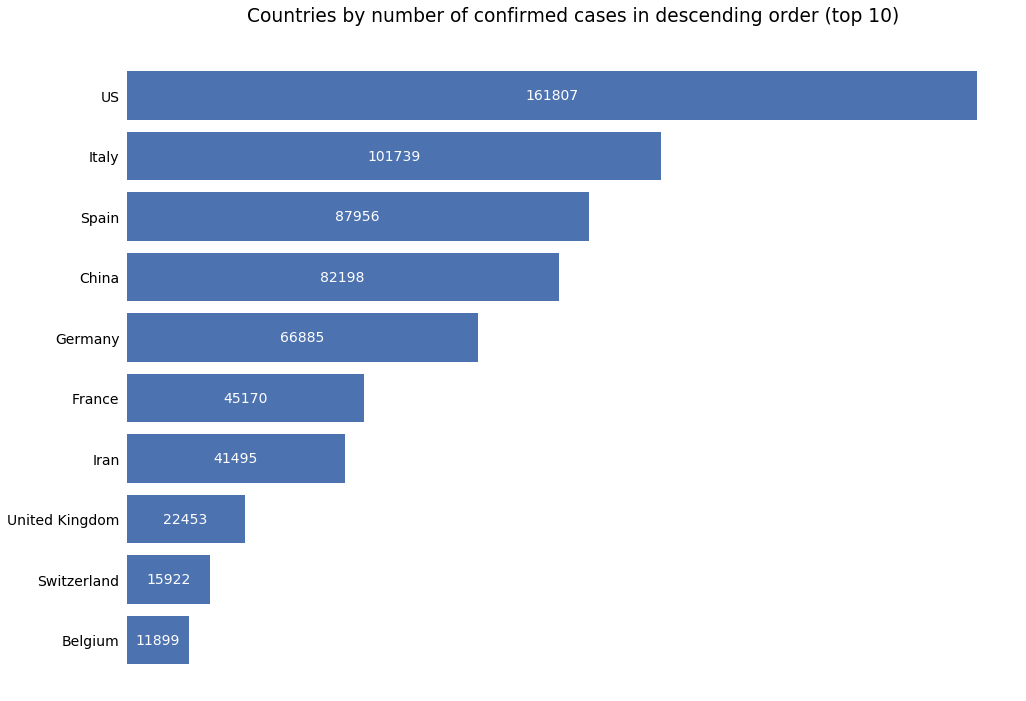

In [96]:
# Showing the top 10 Countries by number of confirmed cases in a bar plot
plot_cust_hbar(conf_top_10.sort_values(),
               figsize_w=16, figsize_h=12,
               frame=False, grid=False,
               ref_font_size=14,
               title_text="Countries by number of confirmed cases "\
                          "in descending order (top 10)",
               title_offset=20,
               color_numb=0,
               categ_labels=True,
               labels=None,
               rot=0,
               show_values=True,
               omitted_value=0,
               percent=False,
               center_al=True,
               visible_digits=2)

In [97]:
# The top 10 Countries by number of recovered cases in descending order
recov_top_10 = daily_rep_group.sort_values(by ='Recovered', ascending = False).\
               head(10)['Recovered']

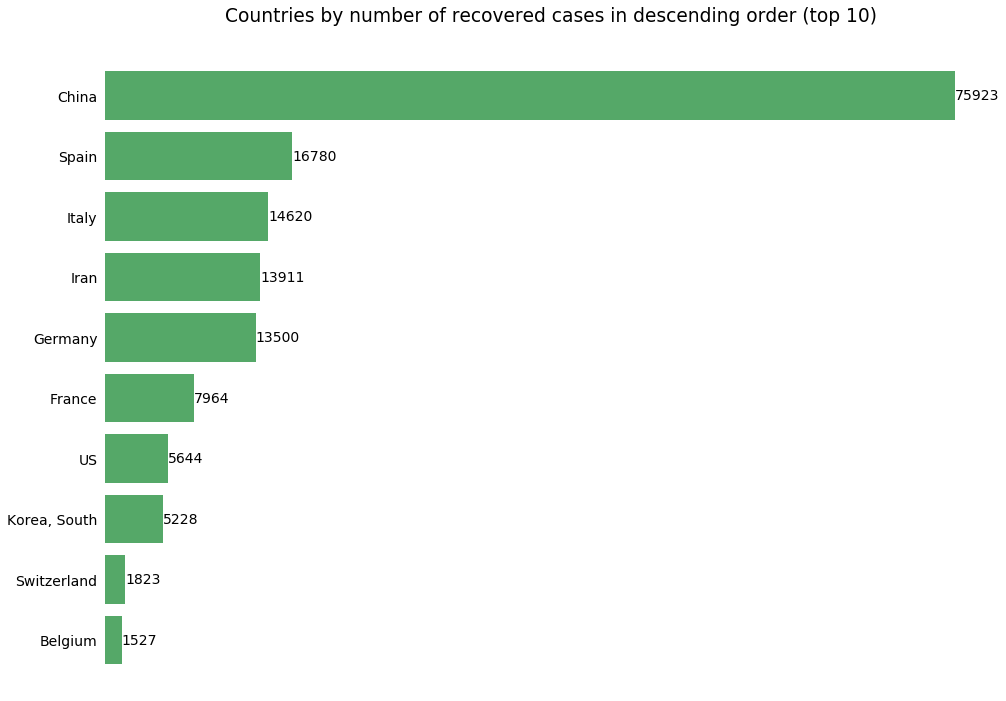

In [98]:
# Showing the top 10 Countries by number of recovered cases in a bar plot
plot_cust_hbar(recov_top_10.sort_values(),
               figsize_w=16, figsize_h=12,
               frame=False, grid=False,
               ref_font_size=14,
               title_text="Countries by number of recovered cases "\
                          "in descending order (top 10)",
               title_offset=20,
               color_numb=2,
               categ_labels=True,
               labels=None,
               rot=0,
               show_values=True,
               omitted_value=0,
               percent=False,
               center_al=False,
               visible_digits=2)

In [99]:
# The top 10 Countries by number of deceased cases in descending order
deceas_top_10 = daily_rep_group.sort_values(by ='Deaths', ascending = False).\
                head(10)['Deaths']

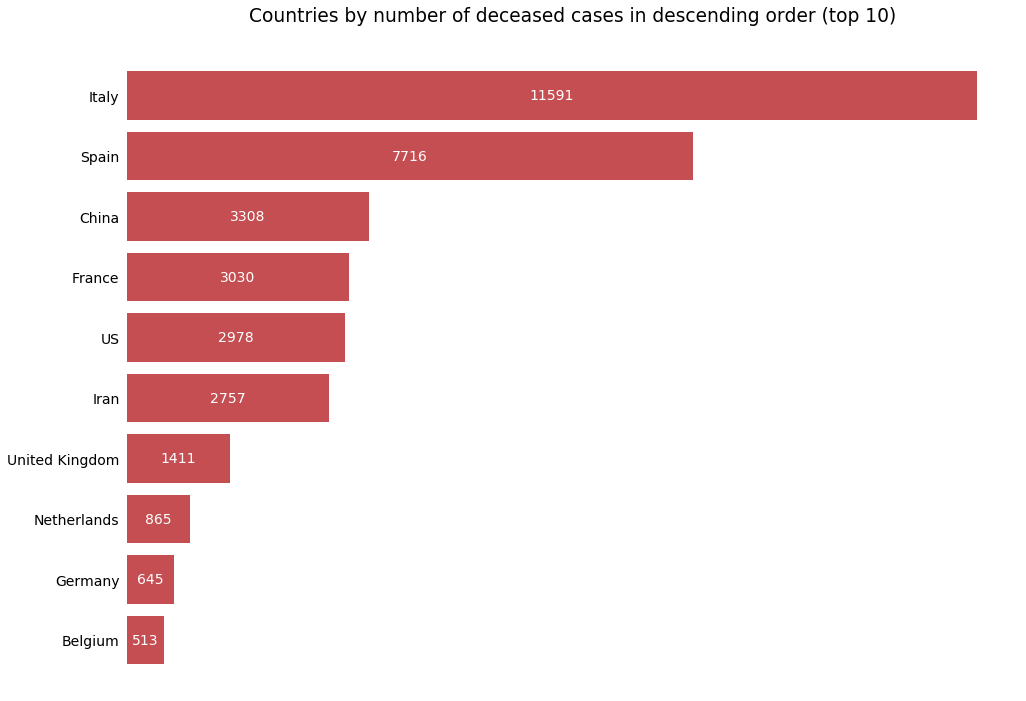

In [100]:
# Showing the top 10 Countries by number of deceased cases in a bar plot
plot_cust_hbar(deceas_top_10.sort_values(),
               figsize_w=16, figsize_h=12,
               frame=False, grid=False,
               ref_font_size=14,
               title_text="Countries by number of deceased cases "\
                          "in descending order (top 10)",
               title_offset=20,
               color_numb=3,
               categ_labels=True,
               labels=None,
               rot=0,
               show_values=True,
               omitted_value=0,
               percent=False,
               center_al=True,
               visible_digits=2)

In [101]:
# Fixing the current number of active cases in US
# (due to mistake in source data)
daily_rep_group.at['US', 'Active'] = \
daily_rep_group.loc['US', ['Confirmed']][0] - \
daily_rep_group.loc['US', ['Recovered']][0] - \
daily_rep_group.loc['US', ['Deaths']][0]

In [102]:
# The top 10 Countries by number of active cases in descending order
act_top_10 = daily_rep_group.sort_values(by ='Active', ascending = False).\
             head(10)['Active']

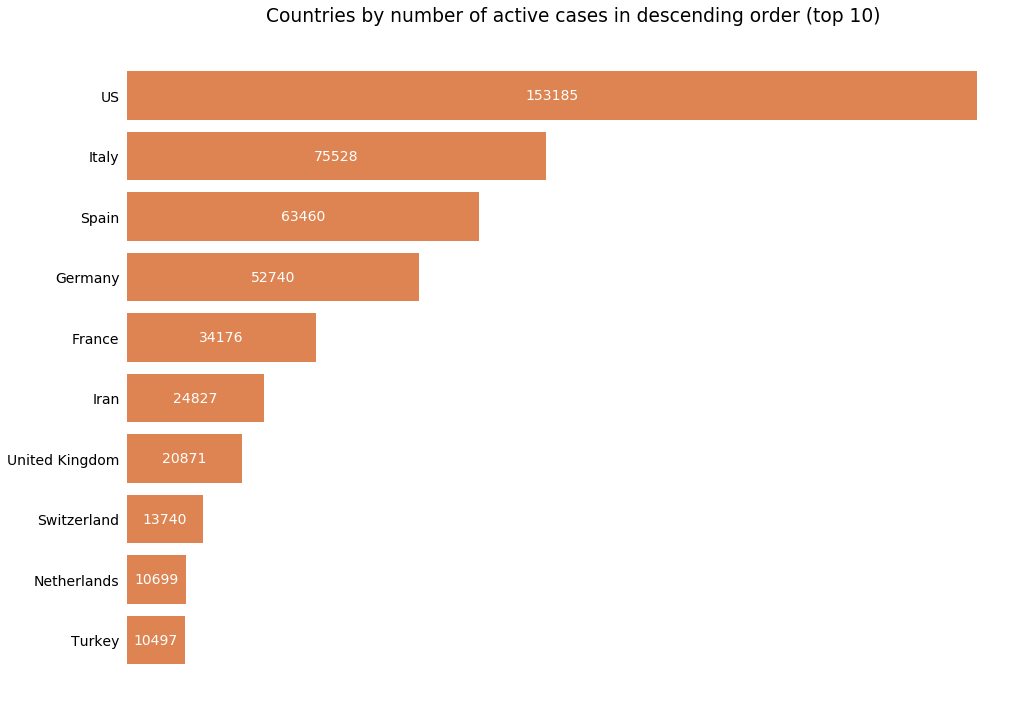

In [103]:
# Showing the top 10 Countries by number of active cases in a bar plot
plot_cust_hbar(act_top_10.sort_values(),
               figsize_w=16, figsize_h=12,
               frame=False, grid=False,
               ref_font_size=14,
               title_text="Countries by number of active cases "\
                          "in descending order (top 10)",
               title_offset=20,
               color_numb=1,
               categ_labels=True,
               labels=None,
               rot=0,
               show_values=True,
               omitted_value=0,
               percent=False,
               center_al=True,
               visible_digits=2)

In [104]:
print("\n(*) Note that for certain Countries the figures in the previous three tables",
      "contain also off shore territories.")
print("For example, for France the numbers include:\n\n",
      "- French Polynesia\n",
      "- New caledonia\n",
      "- St Martina\n",
      "- Saint Barthelemyia\n",
      "- French Guiana\n",
      "- Guadelupe\n",
      "- Mayotte\n",
      "- Reunion\n")


(*) Note that for certain Countries the figures in the previous three tables contain also off shore territories.
For example, for France the numbers include:

 - French Polynesia
 - New caledonia
 - St Martina
 - Saint Barthelemyia
 - French Guiana
 - Guadelupe
 - Mayotte
 - Reunion



### 8.3. Finland <a name="8.3."></a>

In [105]:
# Visualizing the current status in Finland
print("Latest situation in Finland:\n")
print(daily_rep_group.loc['Finland'].to_string())

Latest situation in Finland:

Confirmed    1352
Recovered      10
Deaths         13
Active       1329


## 9. Conclusions <a name="9."></a>

The plots are shortly described in section 7.

Due to the need of daily updates, no additional comment is added here.

## 10. Acknowledgements <a name="10."></a>  

Many thanks to [Johns Hokpins University](https://www.jhu.edu/) for sharing and maintaining daily the source csv files.

Many thanks to Coursera for providing a very informative [course](https://www.coursera.org/learn/covid-19/home/welcome).

Many thanks to colleagues and friends who have contributed by providing links and comments.

---

In [106]:
print("Last plotted day:", dt.datetime.strptime(last_day, "%m-%d-%Y").\
      date().strftime("%d-%b-%Y"))

Last plotted day: 30-Mar-2020


---
<sub>Used software:</sub><br>
<sub>- Jupyter Notebook server 6.0.1</sub><br>
<sub>- Python 3.6.8</sub><br>
<sub>- numpy 1.17.3</sub><br>
<sub>- pandas 0.25.2</sub><br>
<sub>- matplotlib 3.1.2</sub><br>
<sub>- seaborn 0.9.0</sub><br>
<sub>- regex 2019.8.19</sub><br>
<sub>on top of Linux Ubuntu 18.04</sub><br>